In [1]:
import matplotlib as mpl

import os
import glob
import json
import re

import pandas as pd
import numpy as np
import pylab as pl
import seaborn as sns
# import cPickle as pkl
import pickle as pkl
import matplotlib.colors as mcolors
import importlib

In [52]:
import utils as util
import process_datafiles as procd
import plotting as plotting
import aggregate_data as aggr


import assign_phase as ph
import scipy.stats as spstats

In [3]:
import aggregate_data as aggr

In [10]:
import pprint 
pp = pprint.PrettyPrinter(indent=4)

In [4]:
importlib.reload(aggr)

<module 'aggregate_data' from '/home/julianarhee/Repositories/trainingtracker/three_port/aggregate_data.py'>

# Load data

In [5]:
rootdir = '/n/coxfs01/behavior-data'
paradigm = 'threeport'

processed_dir = os.path.join(rootdir, paradigm, 'processed')

metadata = util.get_metadata(paradigm, rootdir=rootdir, filtered=False, create_meta=False)


Loading existing metadata: /n/coxfs01/behavior-data/threeport/metadata.pkl


In [6]:
#### Get all animals in specified cohorts
#cohort_list = ['AK', 'AL', 'AM']
#cohort_list = ['AG', 'AJ']
# cohort_list = ['AK', 'AL', 'AM', 'AN', 'AG', 'AJ'] #, 'AO']
# excluded_animals = ['AM9', 'AM10', 'AM11', 'AM12', 'AJ2']

cohort_list = [ 'AN', 'AG', 'AJ']
cohortdf = aggr.combine_cohorts_to_dataframe(metadata, cohort_list=cohort_list, excluded_animals=excluded_animals)


combining data from 3 cohorts: ['AN', 'AG', 'AJ']
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... skipping AJ2
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df
... loading existing df


# Select phase

In [7]:
_ = ph.print_phase_lookup()

{   -1: 'other',
    0: 'always_reward',
    1: 'default',
    2: 'size',
    3: 'depth_rotation',
    4: 'cross',
    5: 'size_and_depth_rotation',
    6: 'depth_and_planar_rotation',
    7: 'morph',
    8: 'newstimuli',
    9: 'fine_grained_size',
    10: 'fine_grained_depth_rotation',
    11: 'fine_grained_size_and_depth_rotation',
    12: 'transparency',
    13: 'clutter',
    14: 'light_position',
    15: 'x_rotation',
    16: 'position',
    17: 'punishcycle_long',
    18: 'punishcycle_short',
    19: 'no_min_RT'}


In [8]:
#### Select phase to analyze
phase_list = [1, 2, 3, 4, 5, 7] #, 7]

#### Get data for current phase
alldf = aggr.get_cohort_data_by_phase(cohortdf, phase_list=phase_list, cohort_list=cohort_list)

Loading existing metadata: /n/coxfs01/behavior-data/threeport/metadata.pkl
... loading phase data...
/n/coxfs01/behavior-data/threeport/processed/meta/phases_AN.pkl
Loading existing metadata: /n/coxfs01/behavior-data/threeport/metadata.pkl
... loading phase data...
/n/coxfs01/behavior-data/threeport/processed/meta/phases_AG.pkl
Loading existing metadata: /n/coxfs01/behavior-data/threeport/metadata.pkl
... loading phase data...
/n/coxfs01/behavior-data/threeport/processed/meta/phases_AJ.pkl


In [9]:
print("Phase:", sorted(alldf['phase'].unique()))

object_ids = alldf['objectid'].unique()
animal_ids = alldf['animalid'].unique()
print("%i unique animals" % len(animal_ids))
print("Object ids:", object_ids)

no_feedback_flag = len(alldf[alldf['no_feedback']==True])>0
print("Has no-feedback trials:", no_feedback_flag)
no_fb = {}

Phase: [1, 3, 4, 5, 7]
32 unique animals
Object ids: ['2' '1' 'morph']
Has no-feedback trials: True


In [11]:
#### Assign port mapping to df
portmapping, alldf = aggr.add_portmap(alldf)
for p, plist in portmapping.items():
    print('%s:\n    ' % p, plist)

Object1_Port1:
     ['AN3', 'AN4', 'AN7', 'AN8', 'AJ10', 'AJ12', 'AJ9']
Object1_Port3:
     ['AG1', 'AG10', 'AG11', 'AG2', 'AG3', 'AG4', 'AG5', 'AG6', 'AG7', 'AG8', 'AG9', 'AJ13', 'AJ14', 'AJ15', 'AJ16', 'AJ6', 'AJ7', 'AN1', 'AN2', 'AN5', 'AN6', 'AJ1', 'AJ4', 'AJ5', 'AJ8']


In [12]:
##### Assign box info
# df, bboxes, towers = aggr.assign_box_info(df, metadata)

# print("Towers:", df['tower'].unique())
# print("Boxes:", sorted(df['boxnum'].unique()))

transform_names = ['depth_rotation', 'light_position', 'pos_x', 'pos_y', 'rotation', 'size', 'x_rotation']
for t in transform_names:
    print('%s: %i' % (t, len(alldf[t].unique())))

depth_rotation: 9
light_position: 2
pos_x: 5
pos_y: 1
rotation: 1
size: 6
x_rotation: 4


In [37]:
##### Get training sessions only
traindf=alldf[(alldf['phase']>=1) & (alldf['phase']<=4)].copy()

transform_names = ['depth_rotation', 'light_position', 'pos_x', 'pos_y', 'rotation', 'size', 'x_rotation']
for t in transform_names:
    print('%s: %i' % (t, len(traindf[t].unique())))
    
traindf.head()


depth_rotation: 9
light_position: 2
pos_x: 5
pos_y: 1
rotation: 1
size: 6
x_rotation: 4


depth_rotation  duration light_position             name  no_feedback  \
0               0   5131594           None  Blob_2_RotDep_0        False   
1               0   5731459           None  Blob_2_RotDep_0        False   
2               0   5348271           None  Blob_1_RotDep_0        False   
3               0    416529           None  Blob_2_RotDep_0        False   
4               0   5114931           None  Blob_2_RotDep_0        False   

  object  outcome  outcome_time  pos_x  pos_y  ... suffix         time  \
0      2  success   77385757828   -0.0    0.0  ...         77385225336   
1      2  success   77515277842   -0.0    0.0  ...         77514132911   
2      1  success   77527533782    0.0    0.0  ...         77526778755   
3      2  failure   77539397752   -0.0    0.0  ...         77539008066   
4      2  success   77682589627   -0.0    0.0  ...         77682077671   

   x_rotation   session animalid  cohort sessionid  objectid phase portmap  
0        None  20180318      AN1      AN  20180318         2     1       0  
1        None  20180318      AN1      AN  20180318         2     1       0  
2        None  20180318      AN1      AN  20180318         1     1       0  
3        None  20180318      AN1      AN  20180318         2     1       0  
4        None  20180318      AN1      AN  20180318         2     1       0  

[5 rows x 24 columns]

In [38]:
# weird_light = [k for k in df['light_position'].unique() if k not in [0, None]]
# weird_xrot = [k for k in df['x_rotation'].unique() if k not in [0, None]]
# weird_pos = [k for k in df['pos_x'].unique() if k not in [0, None]]
# # print(weird_light)
# # print(weird_xrot)
# # print(weird_pos)

known_funky = ['light_position', 'x_rotation', 'pos_x']
remove_=[]
for param in known_funky:
    weird_sesh =  [k for k in traindf[param].unique() if k not in [0, None]]
    print(param, weird_sesh)
    out_ = traindf[traindf[param].isin(weird_sesh)][['animalid', 'sessionid']].drop_duplicates()
    remove_.append(out_)

    

light_position ['0_-10_-10']
x_rotation [-10, 10]
pos_x [-10.0, 10.0, 5.0, -5.0]


In [188]:
remove_ids0 = pd.concat(remove_).drop_duplicates()
remove_ids = [(a, s) for a, s in remove_ids0.values]

standard_df = pd.concat([g for (a, s), g in traindf.groupby(['animalid', 'sessionid']) \
                 if (a, s) not in remove_ids])
standard_df = aggr.add_train_day(standard_df)


# Create output dir

In [95]:
curr_dst_dir = os.path.join(processed_dir, 'morphs', 'controls')
if not os.path.exists(curr_dst_dir):
    os.makedirs(curr_dst_dir)
print(curr_dst_dir)

/n/coxfs01/behavior-data/threeport/processed/morphs/controls


In [1235]:
# analysis_folder = 'bias_checks' #None
# if analysis_folder is None:
#     if len(phase_list) == 1:
#         if phase_list[0]==1:
#             analysis_folder = 'default_view'
#         elif phase_list[0] == 5:
#             analysis_folder = 'test_transforms'
#         else:
#             print("Phases: %s\... pick a folder" % str(phase_list))
#     else:
#         if len(phase_list) > 1:
#             if 1 in phase_list and 5 in phase_list:
#                 analysis_folder = 'standard_phases'
#             elif 1 in phase_list and 3 in phase_list and 5 not in phase_list:
#                 analysis_folder = 'training_phases'
#         else:
#             print("Phases: %s\... pick a folder" % str(phase_list))

# outdir = os.path.join(processed_dir, 'basic_training', analysis_folder) #, 'phase-%i' % curr_phase, 'performance')
# if not os.path.exists(outdir):
#     print("making dir")
#     os.makedirs(outdir)
# print(outdir)

In [40]:
standard_df['phase'].unique()

array([4, 1, 3])

# Set colors and plotting params

In [41]:
phase_list=standard_df['phase'].unique()
cohort_list = standard_df['cohort'].unique()
animalids = standard_df['animalid'].unique()
figid = plotting.get_fig_id(animalids, cohort_list, phase_list)
print(figid)

phase4-1-3_cohorts_AG-AJ-AN
AG1-11 | AJ1-16 | AN1-8


In [42]:
# combine two color maps for 0-50% and 50-100% as in the PNAS paper
pnas_cmap = plotting.get_pnas_cmap()

# Font params
plotting.update_fonts(labelsize=12)

In [43]:
# tower_colors = dict((t, c) for t, c in zip(sorted(towers.keys(), key=util.natural_keys),
#                                            sns.color_palette('colorblind', n_colors=len(towers.keys()))))
# boxpos_colors = dict((t, c) for t, c in zip(np.arange(0, 4),
#                                            sns.color_palette('cubehelix', n_colors=4)))

# feature_colors = {'objectid': sns.color_palette('colorblind', n_colors=2),
#                   'portmap': ['magenta', 'forestgreen'],
#                   'twinx': ['tab:red', 'tab:blue'],
#                   'tower': tower_colors,
#                   'box_pos': boxpos_colors}


## Get training configs

In [1240]:
cohort_list

['AN', 'AG', 'AJ']

In [1254]:
defaults = ph.get_default_params('AG')

default_size = defaults['size']
default_depth_rotation = defaults['depth_rotation']
default_planar_rotation = defaults['planar_rotation']

expected_sizes = defaults['expected_sizes']
expected_drots = defaults['expected_depth_rotations']

defaults

{'size': 30,
 'depth_rotation': 0.0,
 'planar_rotation': 0.0,
 'expected_sizes': array([15., 20., 25., 30., 35., 40.]),
 'expected_depth_rotations': array([-60., -45., -30., -15.,   0.,  15.,  30.,  45.,  60.]),
 'standard_depth_rotations': array([-60., -45., -30., -15.,   0.,  15.,  30.,  45.,  60.]),
 'fine_depth_rotations': array([-60., -55., -50., -45., -40., -35., -30., -25., -20., -15., -10.,
         -5.,   0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,
         50.,  55.,  60.]),
 'check_alwaysreward': False}

In [45]:
# standard_df = alldf[ (alldf['light_position'].isin([None])) & (alldf['pos_x']==0) 
#                & (alldf['x_rotation'].isin([None, 0])) ].copy()

# all_animalids = standard_df['animalid'].unique()
print("Total %i animals" % len(animalids))
print("All phases:", sorted(standard_df['phase'].unique()))

Total 32 animals
All phases: [1, 3, 4]


In [47]:
standard_df['objectid'].unique()

array(['1', '2'], dtype=object)

In [195]:
importlib.reload(aggr)

<module 'aggregate_data' from '/home/julianarhee/Repositories/trainingtracker/three_port/aggregate_data.py'>

In [191]:
standard_df[standard_df['phase']==1].groupby(['animalid', 'phase'])['train_day'].max()

animalid  phase
AG2       1        12
AG6       1         0
AG7       1         1
AG8       1         0
AG9       1         0
AJ10      1         0
AJ14      1         0
AJ15      1        12
AJ16      1        12
AJ5       1         0
AJ6       1         0
AJ7       1         0
AN1       1        23
AN2       1        23
AN3       1        23
AN4       1        23
AN5       1         6
AN6       1        19
AN7       1        21
AN8       1        22
Name: train_day, dtype: int64

In [218]:
len(standard_df['animalid'].unique())


32

In [220]:
pass_animals, missing = aggr.animals_pass_criterion(standard_df, criterion=criterion, fullcross=fullcross,
                                                group_all_conds=False, defaults_only=True, frac_max=0.5)


25 of 32 animals pass min crit. 0.70 accuracy on training. Fail animals 7:
   ['AG10', 'AG3', 'AJ13', 'AJ14', 'AN2', 'AN3', 'AN5']


In [201]:
pass_animals

array(['AG1', 'AG2', 'AG4', 'AG5', 'AG6', 'AG7', 'AG8', 'AG9', 'AJ1',
       'AJ12', 'AJ4', 'AJ5', 'AJ6', 'AJ7', 'AJ8', 'AJ9', 'AN1', 'AN2',
       'AN4', 'AN6', 'AN7', 'AN8'], dtype=object)

In [164]:
pass_animals, missing = aggr.animals_pass_criterion(standard_df, criterion=criterion, fullcross=fullcross,
                                                group_all_conds=False, defaults_only=True, min_train_phase=1)


25 of 32 animals pass min crit. 0.70 accuracy on training. Fail animals 7:
   ['AG10', 'AG3', 'AJ13', 'AJ14', 'AN2', 'AN3', 'AN5']


In [182]:
#### Filter out animals that don't pass crit
fullcross = True
criterion=0.7

crit_str = 'trainviews-crit-%.2f' % criterion if fullcross else 'defaultview-crit-%.2f' % criterion
print(crit_str)

# max_train_phase=4 if fullcross else 1
# phase1_df = standard_df[ (standard_df['object']!='morph') 
#                        & (standard_df['phase']<=max_train_phase) 
#                        & (standard_df['size'].isin([30, 40])) & (standard_df['depth_rotation']==0)]\
#                     .groupby(['animalid', 'phase', 'session', 'objectid'])['outcome'].value_counts().unstack().reset_index()

# phase1_df['n_trials'] = phase1_df['failure']+phase1_df['success']
# phase1_df['accuracy'] = phase1_df['success']/phase1_df['n_trials']

# mean_acc = phase1_df.groupby(['animalid']).mean().reset_index()
# pass_animals = mean_acc[mean_acc['accuracy']>=criterion]['animalid'].unique()
# print(len(pass_animals))

pass_animals, missing = aggr.animals_pass_criterion(standard_df, criterion=criterion, fullcross=fullcross,
                                                group_all_conds=False, defaults_only=True, min_train_phase=1)


trainviews-crit-0.70
25 of 32 animals pass min crit. 0.70 accuracy on training. Fail animals 7:
   ['AG10', 'AG3', 'AJ13', 'AJ14', 'AN2', 'AN3', 'AN5']


In [180]:

pass_animals, missing = aggr.animals_pass_criterion(standard_df, criterion=criterion, fullcross=fullcross,
                                                group_all_conds=True, defaults_only=True, min_train_phase=1)


24 of 32 animals pass min crit. 0.70 accuracy on training. Fail animals 8:
   ['AG10', 'AG3', 'AJ13', 'AJ14', 'AJ15', 'AN2', 'AN3', 'AN5']


In [205]:
#### Filter out animals that don't pass crit
# criterion=0.7
# crit_str = 'trainviews-crit-%.2f' % criterion if crit_on_cross else 'defaultview-crit-%.2f' % criterion
# print(crit_str)

# animalids = phase1_df['animalid'].unique()
# pass_animals = phase1_df[phase1_df['accuracy']>=criterion]['animalid'].unique()
# print("%i of %i animals pass min crit. %.2f accuracy on overall training." \
#           % (len(pass_animals), len(all_animalids), criterion))
# print("Fail animals:\n    ", [k for k in all_animalids if k not in pass_animals])

#### Only include animals that pass CRITERION ^^|
df = standard_df[standard_df.animalid.isin(pass_animals)].copy()
df[['cohort', 'animalid']].drop_duplicates().groupby(['cohort']).count()
print("Total N=%i rats pass thru behavior:\n    " % len(pass_animals), pass_animals)
  

Total N=25 rats pass thru behavior:
     ['AG1' 'AG11' 'AG2' 'AG4' 'AG5' 'AG6' 'AG7' 'AG8' 'AG9' 'AJ1' 'AJ10'
 'AJ12' 'AJ15' 'AJ16' 'AJ4' 'AJ5' 'AJ6' 'AJ7' 'AJ8' 'AJ9' 'AN1' 'AN4'
 'AN6' 'AN7' 'AN8']


In [206]:
#### Double check configs
print(df[(df['phase']==1)]['size'].unique()) 
print(df[(df['phase']==1)]['depth_rotation'].unique())
 
# print("Training size %i | rotation %i" \
#       % (int(df[(df['phase']==1)]['size'].unique()), int(df[(df['phase']==1)]['depth_rotation'].unique())))

print("pos:", df['pos_x'].unique(), df['pos_y'].unique())

print("size:", df.groupby(['cohort'])['size'].unique())
print("depth rotation:", df.groupby(['cohort'])['depth_rotation'].unique())

[30. 40.]
[0]
pos: [0.] [0.]
size: cohort
AG    [30.0, 40.0, 25.0, 20.0, 35.0, 15.0]
AJ    [30.0, 20.0, 35.0, 40.0, 15.0, 25.0]
AN                                  [40.0]
Name: size, dtype: object
depth rotation: cohort
AG    [-15, -45, 0, 30, -60, -30, 45, 15, 60]
AJ    [60, 0, -45, -15, -30, 15, 30, 45, -60]
AN                                        [0]
Name: depth_rotation, dtype: object


## Plot performance

In [186]:
default_size=[30, 40.]
default_depth_rotation=0

default_only=False

default_str = 'DEFAULTVIEW' if default_only else 'TRAINVIEWS' 

if default_only:
    currdf = pd.concat([ g[(g['size']==40) & (g['depth_rotation']==default_depth_rotation)] if cohort=='AN' else\
                          g[(g['size']==30) & (g['depth_rotation']==default_depth_rotation)] \
                               for cohort, g in df.groupby(['cohort'])])

else:
    currdf = df[df['phase']<=4].copy()


currdf
# traindf['train_day'] = -1
# for (animalid, curr_phase), g in traindf.groupby(['animalid', 'phase']):
#     sorted_sessions = list(sorted(g['sessionid'].unique(), key=util.natural_keys))
#     sorted_session_ixs = [sorted_sessions.index(s) for s in g['sessionid']]
#     traindf.loc[g.index, 'train_day'] = sorted_session_ixs
#currdf = aggr.add_train_day(currdf)


In [207]:
# def add_train_day(df_):
#     df_['train_day'] = -1
#     for (animalid, curr_phase), g in df_.groupby(['animalid', 'phase']):
#         sorted_sessions = list(sorted(g['sessionid'].unique(), key=util.natural_keys))
#         sorted_session_ixs = [sorted_sessions.index(s) for s in g['sessionid']]
#         df_.loc[g.index, 'train_day'] = sorted_session_ixs
#     return df_
frac_max=0.7
currdf0=currdf.copy()
currdf = pd.concat([g[g['train_day']>=g['train_day'].max()*frac_max] if ph==1 else g \
                                for ph, g in currdf0.groupby(['phase'])])



In [221]:
rat_group='all'
# rat_group='morph'
# rat_group='invar'

which_rats = '%srats' % rat_group
print(which_rats)

if rat_group=='morph':
    animals_in_group = [a for a, g in currdf.groupby(['animalid']) if 7 in g['phase'].values]
elif rat_group=='invar':
    animals_in_group = [a for a, g in currdf.groupby(['animalid']) if 7 not in g['phase'].values]
else:
    animals_in_group = df['animalid'].unique()

print("%i rats in current group:\n    " % len(animals_in_group),animals_in_group)

# morph_animals = traindf[traindf['phase']<=max_train_phase]['animalid'].unique()
# len(morph_animals)


exclude = ['AJ15', 'AJ16']
animals_in_group = [a for a in animals_in_group if a not in exclude]

allrats
25 rats in current group:
     ['AG1' 'AG11' 'AG2' 'AG4' 'AG5' 'AG6' 'AG7' 'AG8' 'AG9' 'AJ1' 'AJ10'
 'AJ12' 'AJ15' 'AJ16' 'AJ4' 'AJ5' 'AJ6' 'AJ7' 'AJ8' 'AJ9' 'AN1' 'AN4'
 'AN6' 'AN7' 'AN8']


In [222]:
# def get_counts_from_session_df(df_):
#     counts = df_.groupby(['cohort', 'animalid', 'sessionid', 'phase',\
#                           'objectid', 'size', 'depth_rotation', 'portmap'])['outcome'].value_counts().unstack().reset_index()
#     counts['n_total'] = counts['failure'] + counts['success']
#     counts['accuracy'] = counts['success'] / counts['n_total']
#     counts['accuracy'] = counts['accuracy'].astype(float)
    
#     return counts

In [223]:
df_ = currdf[(currdf.animalid.isin(animals_in_group))]
counts = aggr.get_counts_from_session_df(df_, group_all_conds=True)

# counts = traindf[(traindf['phase']<=max_train_phase) & (traindf.animalid.isin(animals_in_group))]\
#                 .groupby(['cohort', 'animalid', 'sessionid', 'phase',\
#                           'objectid', 'size', 'depth_rotation', 'portmap'])['outcome'].value_counts().unstack().reset_index()
# counts['n_total'] = counts['failure'] + counts['success']
# counts['accuracy'] = counts['success'] / counts['n_total']
# counts['accuracy'] = counts['accuracy'].astype(float)

curr_rats = counts['animalid'].unique()
missing = [k for k in animals_in_group if k not in curr_rats]
nrats = len(curr_rats)
print("%i rats miss:\n    " % len(missing), [k for k in animals_in_group if k not in curr_rats])


0 rats miss:
     []


In [224]:
all_ = counts[ (counts.objectid!='morph')].copy()

all_means = counts[ (counts.objectid!='morph')]\
                .groupby(['cohort', 'animalid', 'phase', 'objectid', 'portmap']).mean().reset_index().dropna()

all_means['objectid'] = all_means['objectid'].astype(int) #.dtypes
len(all_means['animalid'].unique())



23

In [225]:
%matplotlib notebook

<IPython.core.display.Javascript object>


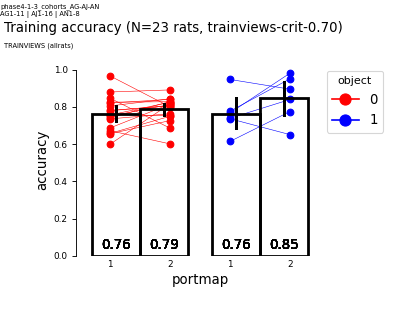

0: (t-stat:-1.21, p=0.24)
1: (t-stat:-1.67, p=0.16)


/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


/n/coxfs01/behavior-data/threeport/processed/morphs/controls allrats_trainviews-crit-0.70_TRAINVIEWS__split_objectid_portmap


In [226]:
plotdf = all_means.copy()

hue='objectid'
columns='portmap' if hue=='objectid' else 'objectid'

fig, ax = pl.subplots(figsize=(5,4))

offset=0.25
marker='o'
compare_var = hue
c1 = 1 if hue=='objectid' else 0
c2 = 2 if hue=='objectid' else 1
curr_metric='accuracy'

plotdf[curr_metric] = plotdf[curr_metric].astype(float)

column_values = sorted(plotdf[columns].unique())
curr_cols = ['r', 'b']

column_colors = dict((k, v) for k, v in zip(column_values, curr_cols))
ax = plotting.pairwise_compare_metric(plotdf, curr_metric=curr_metric, c1=c1, c2=c2, 
                                compare_var=hue, column_var=columns, column_colors=column_colors, ax=ax,)

plotdf.apply(plotting.annotateBars, ax=ax)
ax.set_xlabel(columns)
sns.despine(trim=True, offset=4, bottom=True)

lh = plotting.legend_from_dict(column_colors, markersize=10)
ax.legend(handles=lh, bbox_to_anchor=(1, 1), loc='upper left', title='object')

fig.text(0, 0.95, figid, fontsize=6)
pl.subplots_adjust(left=0.2, right=0.8, bottom=0.2, top=0.8)

nrats = len(plotdf['animalid'].unique())

fig.text(0.01, 0.9, 'Training accuracy (N=%i rats, %s)' % (nrats, crit_str), fontsize=12)
fig.text(0.01, 0.85, "%s (%s)" % (default_str, which_rats), fontsize=6)

figname = '%s_%s_%s__split_objectid_portmap' % (which_rats, crit_str, default_str)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)



In [227]:
plotdf

outcome cohort animalid  phase  objectid  portmap       session       size  \
0           AG      AG1      4         1        0  2.015509e+07  28.928571   
1           AG      AG1      4         2        0  2.015509e+07  28.928571   
2           AG     AG11      4         1        0  2.015528e+07  28.928571   
3           AG     AG11      4         2        0  2.015528e+07  28.928571   
4           AG      AG2      4         1        0  2.015079e+07  28.928571   
5           AG      AG2      4         2        0  2.015079e+07  28.928571   
6           AG      AG4      4         1        0  2.015122e+07  28.928571   
7           AG      AG4      4         2        0  2.015122e+07  28.928571   
8           AG      AG5      4         1        0  2.015079e+07  28.928571   
9           AG      AG5      4         2        0  2.015079e+07  28.928571   
10          AG      AG6      4         1        0  2.015079e+07  28.928571   
11          AG      AG6      4         2        0  2.015079e+07  28.928571   
12          AG      AG7      4         1        0  2.015080e+07  28.928571   
13          AG      AG7      4         2        0  2.015080e+07  28.928571   
14          AG      AG8      4         1        0  2.015078e+07  28.928571   
15          AG      AG8      4         2        0  2.015078e+07  28.928571   
16          AG      AG9      4         1        0  2.015330e+07  28.928571   
17          AG      AG9      4         2        0  2.015330e+07  28.928571   
18          AJ      AJ1      4         1        0  2.016840e+07  28.931419   
19          AJ      AJ1      4         2        0  2.016840e+07  28.917197   
20          AJ     AJ10      4         1        1  2.017065e+07  28.938939   
21          AJ     AJ10      4         2        1  2.017065e+07  28.922156   
22          AJ     AJ12      4         1        1  2.016986e+07  28.928571   
23          AJ     AJ12      4         2        1  2.016986e+07  28.928571   
24          AJ      AJ4      4         1        0  2.016787e+07  28.928571   
25          AJ      AJ4      4         2        0  2.016787e+07  28.928571   
26          AJ      AJ5      4         1        0  2.016817e+07  28.928571   
27          AJ      AJ5      4         2        0  2.016817e+07  28.928571   
28          AJ      AJ6      4         1        0  2.016964e+07  28.928571   
29          AJ      AJ6      4         2        0  2.016964e+07  28.928571   
30          AJ      AJ7      3         1        0  2.017091e+07  28.928571   
31          AJ      AJ7      3         2        0  2.017091e+07  28.928571   
32          AJ      AJ7      4         1        0  2.016965e+07  28.927681   
33          AJ      AJ7      4         2        0  2.016965e+07  28.928571   
34          AJ      AJ8      4         1        0  2.016793e+07  28.928571   
35          AJ      AJ8      4         2        0  2.016793e+07  28.928571   
36          AJ      AJ9      4         1        1  2.016971e+07  28.928571   
37          AJ      AJ9      4         2        1  2.016971e+07  28.928571   
38          AN      AN1      1         1        0  2.018042e+07  40.000000   
39          AN      AN1      1         2        0  2.018042e+07  40.000000   
40          AN      AN4      1         1        1  2.018042e+07  40.000000   
41          AN      AN4      1         2        1  2.018042e+07  40.000000   
42          AN      AN6      1         1        0  2.018042e+07  40.000000   
43          AN      AN6      1         2        0  2.018042e+07  40.000000   
44          AN      AN7      1         1        1  2.018042e+07  40.000000   
45          AN      AN7      1         2        1  2.018042e+07  40.000000   
46          AN      AN8      1         1        1  2.018042e+07  40.000000   
47          AN      AN8      1         2        1  2.018042e+07  40.000000   

outcome  depth_rotation    failure     success     n_total  accuracy  
0              0.000000   5.791545   16.056878   21.673469  0.735180  
1              0.000000   5.075881 

<IPython.core.display.Javascript object>


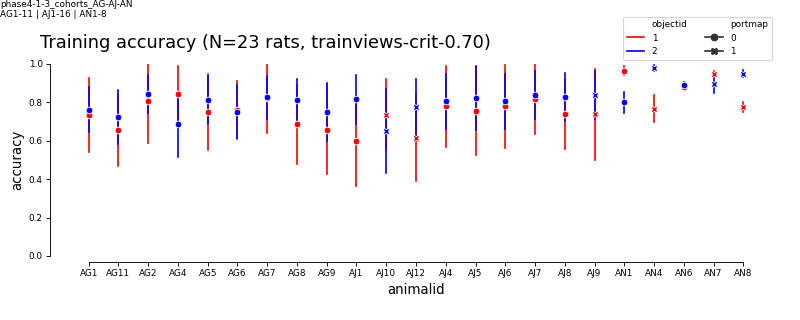

/n/coxfs01/behavior-data/threeport/processed/morphs/controls allrats_trainviews-crit-0.70_TRAINVIEWS__split_objectid_portmap_byrat


In [228]:
plotdf=all_.copy()
nrats = len(plotdf['animalid'].unique())

object_colors = {1: 'r', 2: 'b', '1': 'r', '2': 'b'}
port_markers={'0':'o', '1':'X', 0:'o', 1:'X'}

fig, ax = pl.subplots(figsize=(10,4))
sns.lineplot(x='animalid', y='accuracy', ax=ax, data=plotdf, lw=0, 
             hue='objectid', palette=object_colors, style='portmap', markers=port_markers, 
             err_style='bars', dashes=False, ci='sd')

ax.legend(bbox_to_anchor=(1,1), loc='lower right', fontsize=8, ncol=2)
plotting.label_figure(fig, figid)

fig.text(0.05, 0.85, 'Training accuracy (N=%i rats, %s)' % (nrats, crit_str), fontsize=16)
pl.subplots_adjust(left=0.07, right=0.97, bottom=0.2, top=0.8)
ax.set_ylim([0, 1])
sns.despine(ax=ax, trim=True, offset=5)

figname = '%s_%s_%s__split_objectid_portmap_byrat' % (which_rats, crit_str, default_str)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)




In [1415]:
plotdf_all

outcome cohort animalid sessionid  phase objectid  size  depth_rotation  \
0           AG      AG2  20150219      1        1  30.0               0   
1           AG      AG2  20150219      1        2  30.0               0   
2           AG      AG2  20150220      1        1  30.0               0   
3           AG      AG2  20150220      1        2  30.0               0   
4           AG      AG2  20150223      1        1  30.0               0   
..         ...      ...       ...    ...      ...   ...             ...   
379         AN      AN8  20180418      1        2  40.0               0   
380         AN      AN8  20180419      1        1  40.0               0   
381         AN      AN8  20180419      1        2  40.0               0   
382         AN      AN8  20180420      1        1  40.0               0   
383         AN      AN8  20180420      1        2  40.0               0   

outcome  portmap  failure  success  n_total  accuracy  
0              0     33.0    245.0    278.0  0.881295  
1              0     36.0    243.0    279.0  0.870968  
2              0     20.0    190.0    210.0  0.904762  
3              0     22.0    196.0    218.0  0.899083  
4              0     38.0    104.0    142.0  0.732394  
..           ...      ...      ...      ...       ...  
379            1     32.0    361.0    393.0  0.918575  
380            1     93.0    397.0    490.0  0.810204  
381            1     19.0    481.0    500.0  0.962000  
382            1    124.0    356.0    480.0  0.741667  
383            1     20.0    488.0    508.0  0.960630  

[381 rows x 12 columns]

In [1025]:
dst_dir

NameError: name 'dst_dir' is not defined

In [219]:
df_

outcome animalid  objectid  portmap  failure  success  n_total  accuracy
0            AK1         1        0       65     1798     1863  0.965110
4           AK11         1        1      106     1147     1253  0.915403
6           AK12         1        1       65     1367     1432  0.954609
10           AK3         1        0       54     1746     1800  0.970000
12           AK4         1        0       83     1762     1845  0.955014
14           AK5         1        0       65     1295     1360  0.952206
16           AK6         1        0      195     1189     1384  0.859104
22           AK9         1        1      100     1220     1320  0.924242
26          AL10         1        0       44      498      542  0.918819
32          AL13         1        0       91     1040     1131  0.919540
34          AL14         1        0       13     1137     1150  0.988696
36          AL15         1        0       79      983     1062  0.925612
38          AL16         1        0       25     1059     1084  0.976937
42           AL3         1        1       66     2036     2102  0.968601
44           AL4         1        1      335     1632     1967  0.829690
46           AL5         1        1      272     1524     1796  0.848552
48           AL6         1        1      179     1216     1395  0.871685
50           AL7         1        1       74     1648     1722  0.957027
52           AL8         1        1       83     1670     1753  0.952653
56           AM1         1        1      274     1104     1378  0.801161
58           AM2         1        1       26      376      402  0.935323
60           AM3         1        1       51     1224     1275  0.960000
62           AM4         1        1      106      453      559  0.810376
70           AN1         1        0       32     1156     1188  0.973064
72           AN2         1        0        9      957      966  0.990683
76           AN4         1        1      270     1192     1462  0.815321
78           AN7         1        1       21      612      633  0.966825
80           AN8         1        1      217      753      970  0.776289

In [210]:
len(a_vals), len(b_vals)


(12, 16)

In [34]:
import time

In [35]:
start_t = time.time()

splitdf = [pd.DataFrame({'animalid': animalid,
                         'cohort': re.search(r'(\D+)', animalid).group(),
                          'session': int(re.search(r'(\d+)', sessionid).group()),
                          'sessionid': sessionid,
                          'objectid': objectid,
                          'boxnum': g['boxnum'].unique()[0],
                          'tower':  g['tower'].unique()[0],
                          'boxpos':  g['boxpos'].unique()[0],
                          'portmap':  g['portmap'].unique()[0],
                          'phase':  g['phase'].unique()[0],
                          'mean_rt': g['response_time'].mean(),
                          'split_accuracy': g['outcome'].value_counts()['success'] / float(g['outcome'].value_counts().sum()) \
                                    if 'success' in g['outcome'].value_counts().keys() else 0.,
                          'n_trials': float(g['outcome'].value_counts().sum())}, index=[i])\
                               for i, ((animalid, sessionid, objectid), g) \
                  in enumerate(df.groupby(['animalid', 'sessionid', 'objectid']))]
splitdf = pd.concat(splitdf, axis=0)
end_t = time.time() - start_t
print("Elapsed: {0:.2f}sec".format(end_t))


Elapsed: 15.02sec


In [36]:
start_t = time.time()
perfdf = [pd.DataFrame({'animalid': animalid,
                         'cohort': re.search(r'(\D+)', animalid).group(),
                          'session': int(re.search(r'(\d+)', sessionid).group()),
                          'sessionid': sessionid,
                          'boxnum': g['boxnum'].unique()[0],
                          'tower':  g['tower'].unique()[0],
                          'boxpos':  g['boxpos'].unique()[0],
                          'portmap':  g['portmap'].unique()[0],
                          'phase':  g['phase'].unique()[0],
                          'mean_rt': g['response_time'].mean(),
                          'overall_accuracy': g['outcome'].value_counts()['success'] / float(g['outcome'].value_counts().sum()) \
                                    if 'success' in g['outcome'].value_counts().keys() else 0.,
                          'n_trials': float(g['outcome'].value_counts().sum())}, index=[i])\
                               for i, ((animalid, sessionid), g) \
                  in enumerate(df.groupby(['animalid', 'sessionid']))]
perfdf = pd.concat(perfdf, axis=0)
end_t = time.time() - start_t
print("Elapsed: {0:.2f}sec".format(end_t))

Elapsed: 8.02sec


## Filter over-trained sessions out

In [41]:
plot_overtrained = False

In [42]:
AN_df = perfdf[perfdf['cohort']=='AN'].copy()
AN_df['train_day'] = [-1 for _ in np.arange(0, len(AN_df))]

AN_df_split = splitdf[splitdf['cohort']=='AN'].copy()
AN_df_split['train_day'] = [-1 for _ in np.arange(0, len(AN_df_split))]

for (animalid), g in AN_df.groupby(['animalid']):
    sorted_sessions = list(sorted(g['sessionid'].unique(), key=util.natural_keys))
    sorted_session_ixs = [sorted_sessions.index(s) for s in g['sessionid']]
    AN_df.loc[g.index, 'train_day'] = sorted_session_ixs
    
for (animalid), g in AN_df_split.groupby(['animalid']):
    sorted_sessions = list(sorted(g['sessionid'].unique(), key=util.natural_keys))
    sorted_session_ixs = [sorted_sessions.index(s) for s in g['sessionid']]
    AN_df_split.loc[g.index, 'train_day'] = sorted_session_ixs
    

#### Create filtered df

In [43]:
thr = 0.7

AN_last_session = {}
for animalid, g in AN_df.groupby(['animalid']):
    curr_vals = g[g['overall_accuracy']>=thr].sort_values(by='session') #['overall_accuracy']
    if len(curr_vals) == 0:
        last_sess = g.sort_values(by='session')['session'].iloc[-1]
    else:
        last_sess = curr_vals['session'].iloc[0]
    AN_last_session[animalid] = last_sess
       

AN_df_filtered = pd.concat([g[g['session']<=AN_last_session[animalid]] \
               for animalid, g in AN_df.groupby(['animalid'])])


ValueError: No objects to concatenate

In [44]:
no_overtrained = AN_last_session.copy()

testdf = pd.concat([g[g['session']<=no_overtrained[animalid]] if animalid in no_overtrained.keys() else g \
               for animalid, g in perfdf.groupby(['animalid'])]).reset_index(drop=True)

testdf_split = pd.concat([g[g['session']<=no_overtrained[animalid]] if animalid in no_overtrained.keys() else g \
               for animalid, g in splitdf.groupby(['animalid'])]).reset_index(drop=True)


In [45]:
if plot_overtrained:
    hue = 'objectid' # 'session' #'cohort' # None
    factor = 'bbox'

    palette = 'cubehelix' if hue=='train_day' else None
    if palette is None and hue in feature_colors.keys():
        palette = feature_colors[hue]

    plot_each_session = False
    ignore_AN = True

    point_str = 'plot-each-session' if plot_each_session else ''
    hue_str = 'hue-%s' % hue if hue is not None else ''

    if 'object' in hue:
        tdf = AN_df_split.copy()
        metric = 'split_accuracy'
    else:
        tdf = AN_df.copy()
        metric = 'overall_accuracy'

    fig, ax = pl.subplots(figsize=(6,4), dpi=dpi)
    sns.boxplot(x=factor, y=metric, data=tdf, ax=ax,
               fliersize=0, width=.7, dodge=True, color='white')
    ax.set_ylim([0, 1])

    # iterate over boxes to make them outlines only
    outline_boxplot(ax)

    color = 'k' if hue is None else None
    if plot_each_session or hue is not None:
        sns.swarmplot(x=factor, y=metric, data=tdf, ax=ax,
                   hue=hue, color=color, alpha=0.7, palette=palette)

    sns.despine(trim=True, offset=4, bottom=True)
    ax.tick_params(axis='x', size=0)
    if hue is not None:
        ax.legend(bbox_to_anchor=(1.1, 1), title=hue, fontsize=8)

    pl.subplots_adjust(bottom=0.2, right=0.75, top=0.9)


    fig.text(0, 0.95, '%s%s' % (figid, add_str), fontsize=6)

    figname = '%s_accuracy_boxplot_%s' % (factor, hue_str)
    pl.savefig(os.path.join(processed_dir, 'basic_training', 'default_view', 'AN', '%s.png' % figname))
    print(figname)


In [46]:
if plot_overtrained:
    hue = 'train_day' # 'session' #'cohort' # None
    factor = 'bbox'

    palette = 'cubehelix' if hue=='train_day' else 'colorblind'

    plot_each_session = False
    ignore_AN = True

    point_str = 'plot-each-session' if plot_each_session else ''
    hue_str = 'hue-%s' % hue if hue is not None else ''


    fig, ax = pl.subplots(figsize=(6,4), dpi=dpi)
    sns.boxplot(x=factor, y='overall_accuracy', data=AN_df_filtered, ax=ax,
               fliersize=0, width=.7, dodge=True, color='white')
    ax.set_ylim([0, 1])

    # iterate over boxes to make them outlines only
    outline_boxplot(ax)

    color = 'k' if hue is None else None
    if plot_each_session or hue is not None:
        sns.swarmplot(x=factor, y='overall_accuracy', data=AN_df_filtered, ax=ax,
                   hue=hue, color=color, alpha=0.7, palette=palette)

    sns.despine(trim=True, offset=4, bottom=True)
    ax.tick_params(axis='x', size=0)
    if hue is not None:
        ax.legend(bbox_to_anchor=(1.1, 1), title=hue, fontsize=8)

    pl.subplots_adjust(bottom=0.2, right=0.75, top=0.9)


    fig.text(0, 0.95, '%s%s' % (figid, add_str), fontsize=6)

    figname = '%s_accuracy_boxplot_%s_phase1-filtered' % (factor, hue_str)
    pl.savefig(os.path.join(processed_dir, 'basic_training', 'default_view', 'AN', '%s.png' % figname))
    print(figname)


# Visualize some overall stats

/home/julianarhee/anaconda2/envs/behavior/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


accuracy_by_boxnum_hue-tower_violin
/n/coxfs01/behavior-data/threeport/processed/basic_training/bias_checks


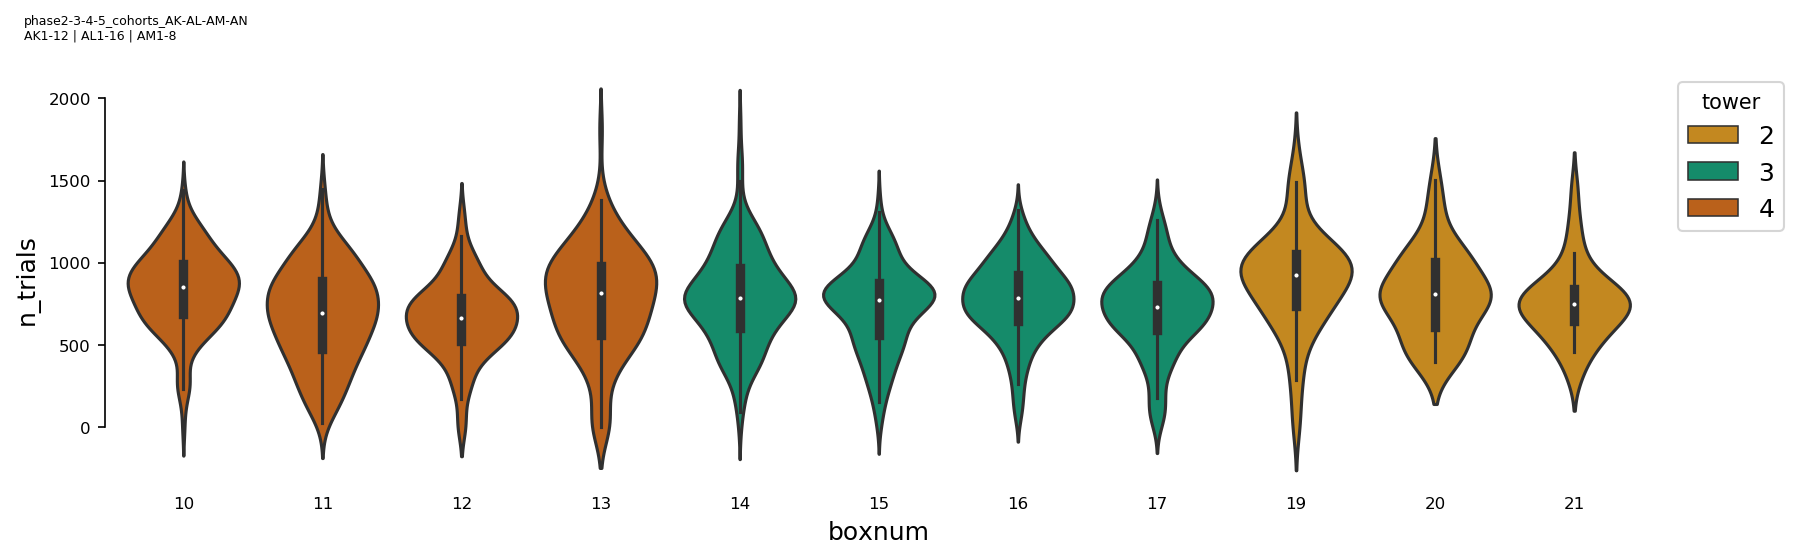

In [47]:
factor = 'boxnum'
hue = 'tower'
plot_type = 'violin'
metric = 'n_trials'
tdf = testdf.copy()

if metric is None:
    if 'object' in hue or 'object' in factor:
        tdf = testdf_split.copy()
        metric = 'split_accuracy'

    else:
        tdf = testdf.copy()
        metric = 'overall_accuracy'
    
palette = feature_colors[hue] if hue in feature_colors.keys() else 'colorblind'


fig, ax = pl.subplots(figsize=(12,4), dpi=dpi)
if plot_type == 'violin':
    sns.violinplot(x=factor, y=metric, data=tdf, ax=ax,
                hue=hue, dodge=hue!='tower', palette=palette, width=0.8)
else:
    sns.stripplot(x=factor, y=metric, data=testdf, ax=ax,
                    hue=hue, dodge=hue!='tower', palette=palette, alpha=0.5)
if 'accuracy' in metric:
    ax.set_ylim([-0.1, 1.1])

sns.despine(trim=True, offset=4, bottom=True)
ax.tick_params(axis='x', size=0)
ax.legend(bbox_to_anchor=(1.1, 1), title=hue)
fig.text(0, 0.95, figid, fontsize=6)

pl.subplots_adjust(bottom=0.2, right=0.9, top=0.9, left=0.05)

figname = 'accuracy_by_%s_hue-%s_%s' % (factor, hue, plot_type)
#pl.savefig(os.path.join(outdir, '%s.png' % figname))
#pl.savefig(os.path.join(outdir, '%s.svg' % figname))

print(figname)
print(outdir)

overall_accuracy_by_boxnum_hue-None_gray_c
/n/coxfs01/behavior-data/threeport/processed/basic-training/default-view


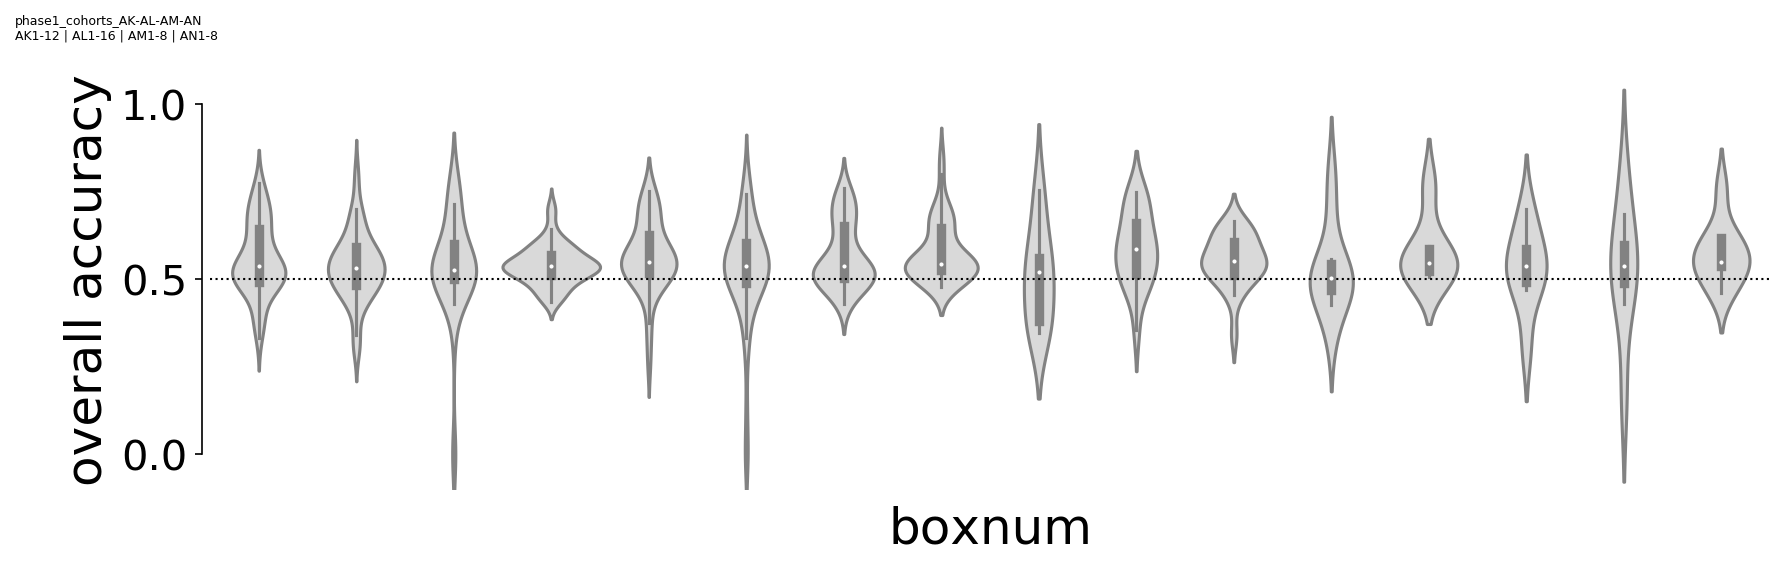

In [1567]:
factor = 'boxnum'
metric = 'overall_accuracy'

hue = None #'tower'
fig.patch.set_alpha(0.)
ax.patch.set_alpha(0.)


palette = feature_colors[hue] if hue in feature_colors.keys() else 'colorblind'
palette = None if hue is None else palette

fig, ax = pl.subplots(figsize=(13,4), dpi=dpi)

cval = 0.85
col = (cval, cval, cval)

sns.violinplot(x=factor, y=metric, data=testdf, ax=ax, color=col,
              hue=None, palette=None, width=1., dodge=False)

if 'accuracy' in metric:
    ax.set_ylim([-0.1, 1.1])
    ax.set_yticks([0, 0.5, 1.0])
    ax.axhline(y=0.5, linestyle=':', lw=1, color='k')

sns.despine(trim=True, offset=4, bottom=True)
ax.tick_params(axis='x', size=0)
ax.set_xticklabels('')
ax.set_ylabel(metric.replace('_', ' '))

#ax.legend(bbox_to_anchor=(1.1, 1), title=hue)
fig.text(0, 0.95, figid, fontsize=6)

pl.subplots_adjust(bottom=0.2, right=0.9, top=0.9, left=0.1)

figname = '%s_by_%s_hue-%s_gray_c' % (metric, factor, hue)
pl.savefig(os.path.join(outdir, '%s.png' % figname))
pl.savefig(os.path.join(outdir, '%s.svg' % figname))

print(figname)
print(outdir)

In [1540]:
lastdf = pd.concat([g.sort_values(by='session')[-2:] for a, g in testdf.groupby(['animalid'])], axis=0)




In [1542]:
lastdf['n_trials'].min()

112.0

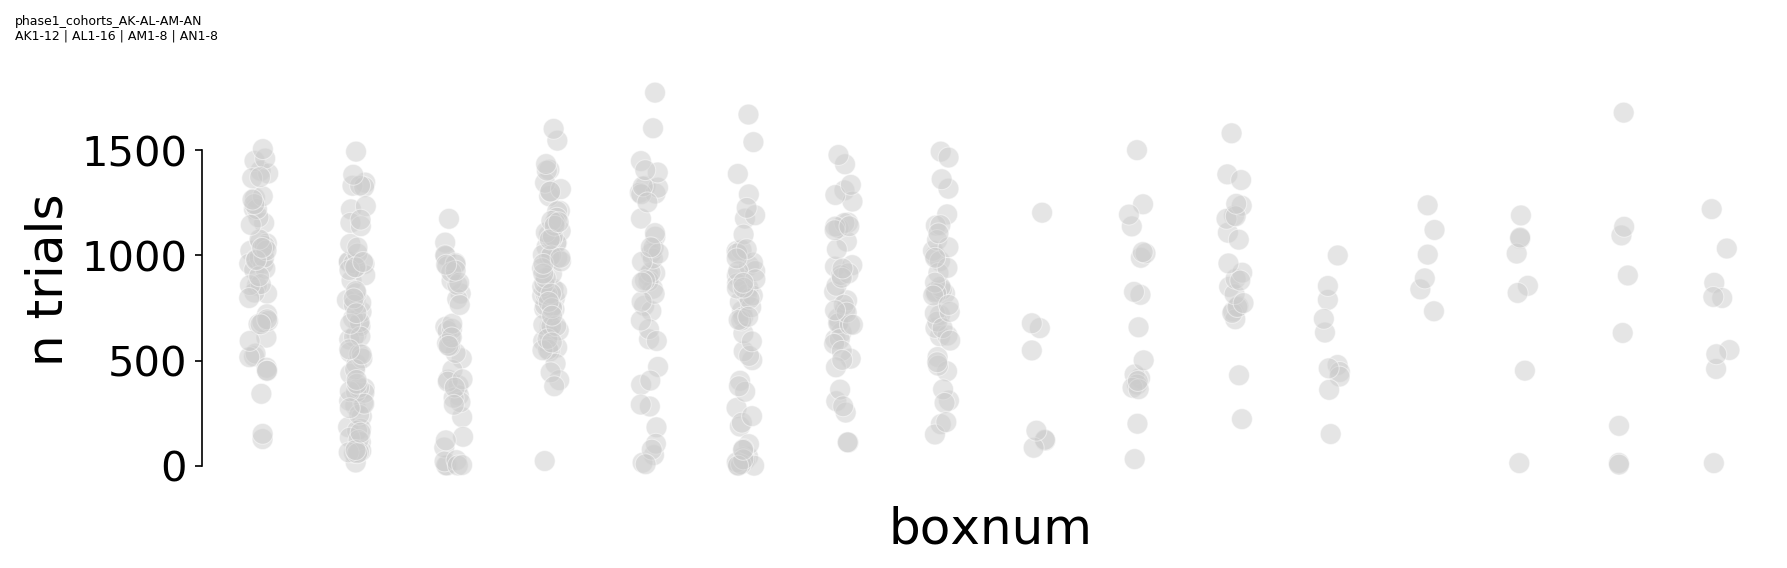

In [1566]:
factor = 'boxnum'
metric = 'n_trials'

hue = None #'tower'
fig.patch.set_alpha(0.)
ax.patch.set_alpha(0.)


palette = feature_colors[hue] if hue in feature_colors.keys() else 'colorblind'
palette = None if hue is None else palette

fig, ax = pl.subplots(figsize=(13,4), dpi=dpi)

cval = 0.8
col = (cval, cval, cval)

sns.stripplot(x=factor, y=metric, data=testdf, ax=ax, color=col, lw=0.5,
              hue=None, palette=None, s=10, alpha=.5, edgecolor='w')

#ax.set_ylim([0, ax.get_ylim()[-1]])

if 'accuracy' in metric:
    ax.set_ylim([-0.1, 1.1])
    ax.set_yticks([0, 0.5, 1.0])
    ax.axhline(y=0.5, linestyle=':', lw=1, color='k')

sns.despine(trim=True, offset=4, bottom=True)
ax.tick_params(axis='x', size=0)
ax.set_xticklabels('')
ax.set_ylabel(metric.replace('_', ' '))

#ax.legend(bbox_to_anchor=(1.1, 1), title=hue)
fig.text(0, 0.95, figid, fontsize=6)

pl.subplots_adjust(bottom=0.2, right=0.9, top=0.9, left=0.1)

figname = '%s_by_%s_hue-%s_gray_c' % (metric, factor, hue)
pl.savefig(os.path.join(outdir, '%s.png' % figname))
pl.savefig(os.path.join(outdir, '%s.svg' % figname))

print(figname)
print(outdir)

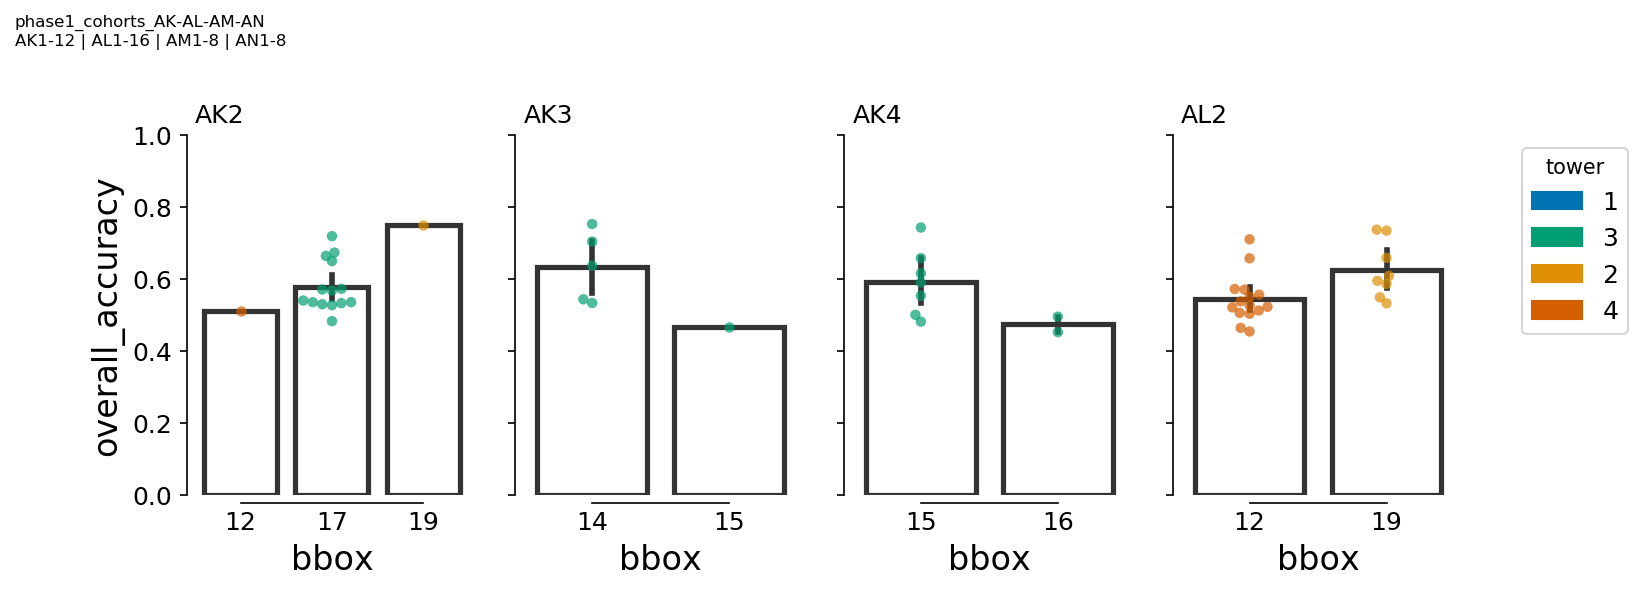

In [1329]:
fig, axes = pl.subplots(1, len(multi_box_animals), figsize=(12,4), dpi=dpi, sharex=False, sharey=True)
for ai, (ax, (animalid, pgroup)) in enumerate(zip(axes.flat, testdf[testdf['animalid'].isin(multi_box_animals)].groupby(['animalid']))):

    sns.barplot(x='bbox', y='overall_accuracy', data=pgroup, ax=ax,
               linewidth=2.5, facecolor=(1, 1, 1, 0),
                 errcolor=".2", edgecolor=".2")
    outline_boxplot(ax)

    sns.swarmplot(x='bbox', y='overall_accuracy', data=pgroup, ax=ax, alpha=0.7,
                 hue='tower', palette=palette)
    
    # remove legend from axis 'ax'
    ax.legend_.remove()
    
    if ai!=0:
        ax.set_ylabel('')
    ax.set_ylim([0, 1])
    ax.tick_params(axis='x', size=0)
    sns.despine(trim=True, offset=4)
    ax.set_title(animalid, loc='left', fontsize=12)
    
fig.text(0, 0.95, figid, fontsize=8)
pl.subplots_adjust(left=0.1, right=0.8, bottom=0.2, wspace=0.2, top=0.8)
leg_patches = [mpatches.Patch(color=col, label=lab) for lab, col in feature_colors['tower'].items()]
pl.legend(handles=leg_patches, bbox_to_anchor=(1.2, 1), title='tower')


pl.savefig(os.path.join(outdir, 'multi_bbox_accuracy_by-animal-plot-session-avg.png'))

In [1204]:
outdir

'/n/coxfs01/behavior-data/threeport/processed/basic-training/standard-phases'

## Plot accuracy by feature

tower_accuracy_hue-box_pos_violin
/n/coxfs01/behavior-data/threeport/processed/basic-training/default-view


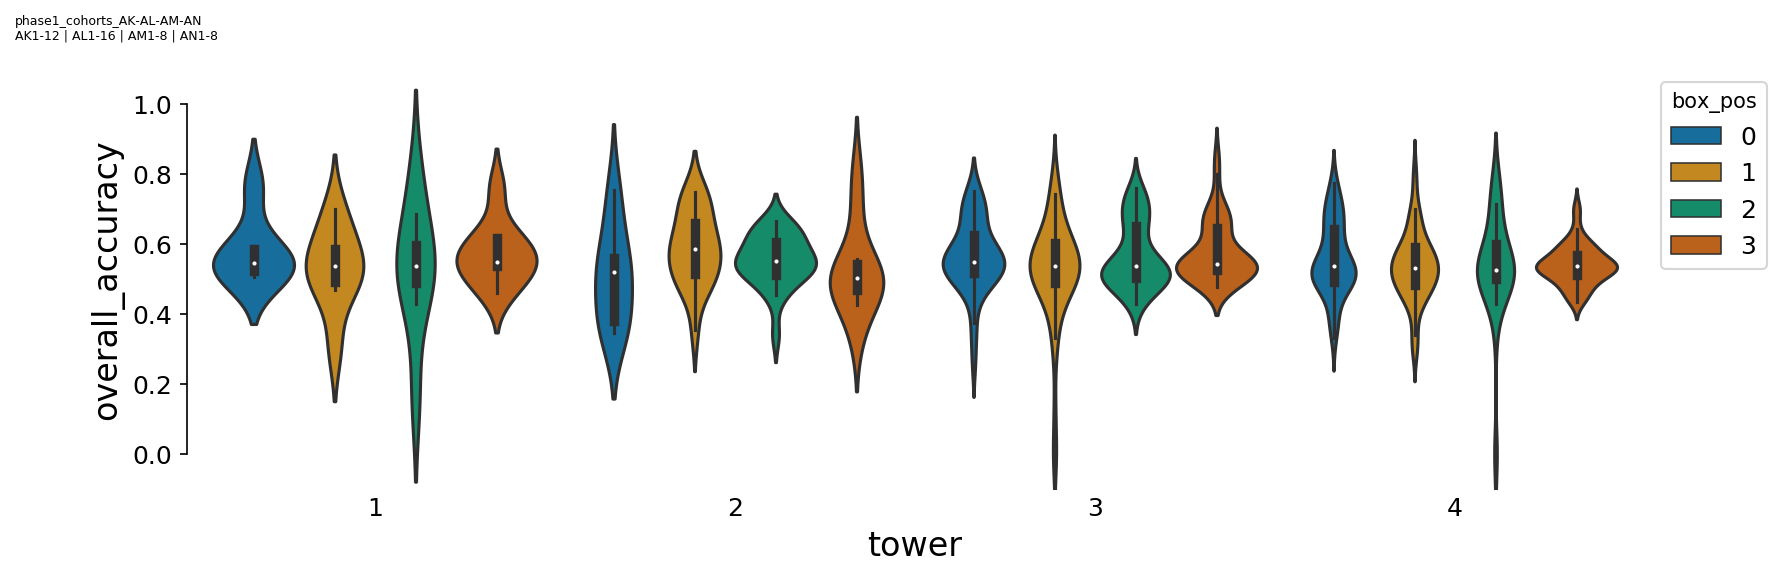

In [1416]:
hue = 'box_pos' #'cohort'  #'cohort' #'cohort' # None
factor = 'tower'
plot_type = 'violin'

# plot_each_session = True

palette = feature_colors[hue] if hue in feature_colors.keys() else 'colorblind'
palette = None if hue is None else palette

# cval = 0.8
# col = (cval, cval, cval)
col = 'k'
color = col if hue is None else None

hue_str = 'hue-%s' % hue if hue is not None else ''

tdf= testdf.copy()
fig, ax = pl.subplots(figsize=(12,4), dpi=dpi)
if plot_type == 'violin':
    sns.violinplot(x=factor, y='overall_accuracy', data=testdf, ax=ax, color=color,
                hue=hue, dodge=hue!='tower', palette=palette, width=0.9)
else:
    sns.stripplot(x=factor, y='overall_accuracy', data=testdf, ax=ax, color=color,
                    hue=hue, dodge=hue!='tower', palette=palette, alpha=0.5, size=10)
ax.set_ylim([-0.1, 1.1])

sns.despine(trim=True, offset=4, bottom=True)
ax.tick_params(axis='x', size=0)
if hue is not None:
    ax.legend(bbox_to_anchor=(1.1, 1), title=hue)

pl.subplots_adjust(bottom=0.2, right=0.9, top=0.9, left=0.1)
    
    
fig.text(0, 0.95, '%s%s' % (figid, add_str), fontsize=6)

figname = '%s_accuracy_%s_%s' % (factor, hue_str, plot_type)
pl.savefig(os.path.join(outdir, '%s.png' % figname))
pl.savefig(os.path.join(outdir, '%s.svg' % figname))

print(figname)
print(outdir)

In [1309]:
towers

{u'1': [22, 23, 24, 25],
 u'2': [18, 19, 20, 21],
 u'3': [14, 15, 16, 17],
 u'4': [10, 11, 12, 13]}

split-tower_accuracy_hue-box_pos


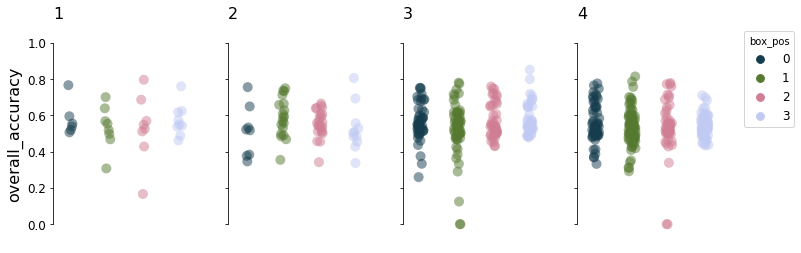

In [1451]:
factor = 'box_pos'
hue = 'box_pos'

sortby = 'tower'

palette = feature_colors[hue] if hue in feature_colors.keys() else 'colorblind'
palette = None if hue is None else palette

fig, axes = pl.subplots(1, len(testdf[sortby].unique()), figsize=(12,4), sharey=True)
for ai, (ax,(sortfeat, g)) in enumerate(zip(axes.flat, testdf.groupby([sortby]))):
            
    sns.stripplot(x=factor, y='overall_accuracy', data=g, ax=ax,
                  palette=palette, hue=hue, s=10, alpha=0.5)
    
    ax.legend_.remove()
    if ai != 0:
        ax.set_ylabel('')
    
    ax.set_ylim([-0.1, 1.1])
    ax.tick_params(axis='x', size=0)
    ax.set_xticklabels('')
    ax.set_xlabel('')
    sns.despine(trim=True, bottom=True)
    ax.set_title(sortfeat, loc='left')
    
ax.legend(bbox_to_anchor=(1.1, 1), title=hue)
# sns.violinplot(x=factor, y=metric, data=tdf[tdf['bbox']!=0], ax=ax,
#            hue=hue, split=split_plot, scale="count", inner="quartile", palette=curr_colors)

figname = 'split-%s_accuracy_hue-%s' % (sortby, hue)
pl.savefig(os.path.join(outdir, '%s.svg' % figname))
print(figname)

split-tower_by-box_pos_accuracy_hue-portmap


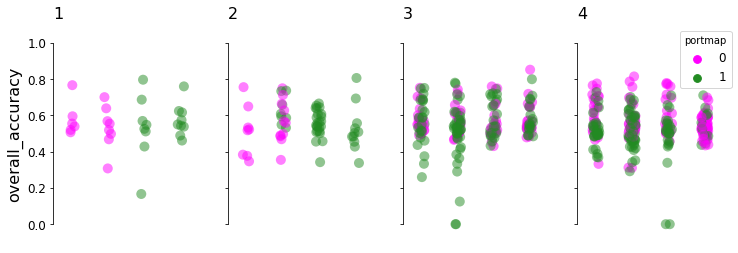

In [1455]:
factor = 'box_pos'
hue = 'portmap'

sortby = 'tower'

palette = feature_colors[hue] if hue in feature_colors.keys() else 'colorblind'
palette = None if hue is None else palette

if hue == 'objectid':
    tdf = testdf_split.copy()
    metric = 'split_accuracy'
else:
    tdf = testdf.copy()
    metric = 'overall_accuracy'
    
fig, axes = pl.subplots(1, len(tdf[sortby].unique()), figsize=(12,4), sharey=True)
for ai, (ax,(sortfeat, g)) in enumerate(zip(axes.flat, tdf.groupby([sortby]))):
            
    sns.stripplot(x=factor, y=metric, data=g, ax=ax,
                  palette=palette, hue=hue, s=10, alpha=0.5)
    
    ax.legend_.remove()
    if ai != 0:
        ax.set_ylabel('')
    
    ax.set_ylim([-0.1, 1.1])
    ax.tick_params(axis='x', size=0)
    ax.set_xticklabels('')
    ax.set_xlabel('')
    sns.despine(trim=True, bottom=True)
    ax.set_title(sortfeat, loc='left')
    
ax.legend(bbox_to_anchor=(1.1, 1), title=hue)
# sns.violinplot(x=factor, y=metric, data=tdf[tdf['bbox']!=0], ax=ax,
#            hue=hue, split=split_plot, scale="count", inner="quartile", palette=curr_colors)

figname = 'split-%s_by-%s_accuracy_hue-%s' % (sortby, factor, hue)
pl.savefig(os.path.join(outdir, '%s.svg' % figname))
print(figname)

bbox_overall-accuracy_hue-portmap_split-violin
/n/coxfs01/behavior-data/threeport/processed/basic-training/default-view


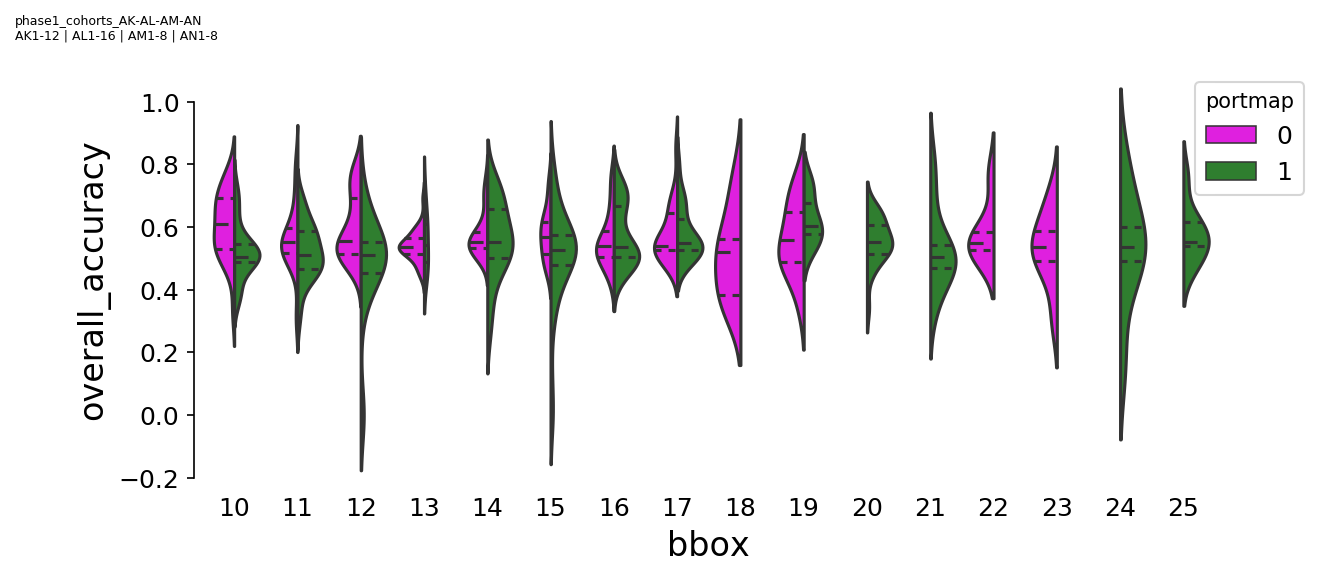

In [1457]:
hue = 'portmap' #'portmap'
factor = 'bbox' #'bbox'


curr_colors = feature_colors[hue]
split_plot = hue is not None

if hue == 'objectid':
    tdf = testdf_split.copy()
else:
    tdf = testdf.copy()
    

metric = 'split_accuracy' if hue=='objectid' else 'overall_accuracy'

fig, ax = pl.subplots(figsize=(10,4), dpi=dpi)
sns.violinplot(x=factor, y=metric, data=tdf[tdf['bbox']!=0], ax=ax,
           hue=hue, split=split_plot, scale="count", inner="quartile", palette=curr_colors)

color = 'k' if hue is None else None
hue_str = 'hue-%s' % hue if hue is not None else ''
plot_type = 'violin' if hue is None else 'split-violin'

sns.despine(trim=True, offset=4, bottom=True)
ax.tick_params(axis='x', size=0)
if hue is not None:
    ax.legend(bbox_to_anchor=(1.1, 1), title=hue)
    
fig.text(0, 0.95, '%s%s' % (figid, add_str), fontsize=6)

pl.subplots_adjust(bottom=0.2, right=0.8, top=0.9)

figname = '%s_%s_%s_%s%s' % (factor, metric.replace('_', '-'), hue_str, plot_type, add_str)
#pl.savefig(os.path.join(outdir, '%s.png' % figname))
print(figname)
print(outdir)

In [911]:
tdf['animalid'].unique()

array(['AK1', 'AK10', 'AK11', 'AK12', 'AK2', 'AK3', 'AK4', 'AK5', 'AK6',
       'AK7', 'AK8', 'AK9', 'AL1', 'AL10', 'AL11', 'AL12', 'AL13', 'AL14',
       'AL15', 'AL16', 'AL2', 'AL3', 'AL4', 'AL5', 'AL6', 'AL7', 'AL8',
       'AL9', 'AM1', 'AM2', 'AM3', 'AM4', 'AM5', 'AM6', 'AM8'],
      dtype=object)

# Stat test interactions

In [1310]:
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp
import statsmodels.api as sm


In [1319]:
# Fits the model with the interaction term
# This will also automatically include the main effects for each factor

standarddf_no0 = testdf[testdf['bbox']!=0].copy()
#standarddf_no0 = standarddf_split[standarddf_split['bbox']!=0].copy()

#model = ols('overall_accuracy ~ C(box_pos)*C(tower)', standarddf_no0).fit()
# model = ols('overall_accuracy ~ C(tower)', standarddf_no0).fit()
model = ols('overall_accuracy ~ C(bbox)', standarddf_no0).fit()

# Seeing if the overall model is significant
print("Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .4f}".format(model=model))
    

Overall model F( 15, 528) =  1.080, p =  0.3725


In [1320]:
# The Durban-Watson tests is to detect the presence of autocorrelation, 
# Jarque-Bera tests the assumption of normality, 
# Omnibus tests the assumption of homogeneity of variance, 
# and the Condition Number assess multicollinearity. 
# Condition Number values over 20 are indicative of multicollinearity.

model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       overall_accuracy   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.080
Date:                Mon, 23 Mar 2020   Prob (F-statistic):              0.372
Time:                        18:59:02   Log-Likelihood:                 442.63
No. Observations:                 544   AIC:                            -853.3
Df Residuals:                     528   BIC:                            -784.5
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.5579      0.015     38.351      0.000       0.529       0.586
C(bbox)[T.11]    -0.0206      0.019     -1.086      0.278      -0.058       0.017
C(bbox)[T.12]    -0.0206      0.022     -0.957      0.339      -0.063       0.022
C(bbox)[T.13]    -0.0162      0.019     -0.836      0.404      -0.054       0.022
C(bbox)[T.14]     0.0082      0.022      0.379      0.705      -0.034       0.050
C(bbox)[T.15]    -0.0335      0.020     -1.651      0.099      -0.073       0.006
C(bbox)[T.16]     0.0098      0.022      0.450      0.653      -0.033       0.052
C(bbox)[T.17]     0.0199      0.022      0.909      0.364      -0.023       0.063
C(bbox)[T.18]    -0.0469      0.041     -1.139      0.255      -0.128       0.034
C(bbox)[T.19]     0.0306      0.029      1.060      0.289      -0.026       0.087
C(bbox)[T.20]    -0.0029      0.027     -0.109      0.913      -0.055       0.049
C(bbox)[T.21]    -0.0317      0.036     -0.883      0.377      -0.102       0.039
C(bbox)[T.22]     0.0229      0.047      0.490      0.624      -0.069       0.115
C(bbox)[T.23]    -0.0257      0.041     -0.624      0.533      -0.107       0.055
C(bbox)[T.24]    -0.0284      0.041     -0.691      0.490      -0.109       0.052
C(bbox)[T.25]     0.0154      0.039      0.393      0.695      -0.061       0.092
==============================================================================
Omnibus:                       98.481   Durbin-Watson:                   1.246
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              448.004
Skew:                          -0.722   Prob(JB):                     5.22e-98
Kurtosis:                       7.205   Cond. No.                         14.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1321]:
# Creates the ANOVA table
res = sm.stats.anova_lm(model, typ= 2)
res

sum_sq     df         F    PR(>F)
C(bbox)   0.191907   15.0  1.079562  0.372454
Residual  6.257298  528.0       NaN       NaN

In [1322]:
mc = statsmodels.stats.multicomp.MultiComparison(standarddf_no0['overall_accuracy'], standarddf_no0['box_pos'])
mc_results = mc.tukeyhsd()
print(mc_results)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  0      1    -0.0208  -0.0548 0.0131 False 
  0      2    -0.0078  -0.0439 0.0283 False 
  0      3     -0.005  -0.0404 0.0304 False 
  1      2     0.0131  -0.0202 0.0464 False 
  1      3     0.0158  -0.0166 0.0483 False 
  2      3     0.0028   -0.032 0.0375 False 
--------------------------------------------


In [1323]:
mc = statsmodels.stats.multicomp.MultiComparison(standarddf_no0['overall_accuracy'], standarddf_no0['tower'])
mc_results = mc.tukeyhsd()
print(mc_results)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  1      2     0.0017  -0.0602 0.0635 False 
  1      3     0.0037  -0.0507 0.058  False 
  1      4    -0.0098  -0.0632 0.0437 False 
  2      3     0.002   -0.0389 0.043  False 
  2      4    -0.0114  -0.0512 0.0284 False 
  3      4    -0.0134  -0.0402 0.0133 False 
--------------------------------------------


In [1324]:
standarddf['tower'].unique()

array([u'3', u'4', u'2'], dtype=object)

In [1325]:
vs = [g['overall_accuracy'].values for p, g in standarddf_no0.groupby(['box_pos'])]
spstats.kruskal(*vs)

KruskalResult(statistic=1.2707700500961276, pvalue=0.7360854395120571)

In [1326]:
vs = [g['overall_accuracy'].values for p, g in standarddf_no0.groupby(['tower'])]
spstats.kruskal(*vs)

KruskalResult(statistic=3.32534244945416, pvalue=0.3441309941800922)

In [1327]:
vs = [g['overall_accuracy'].values for p, g in standarddf_no0.groupby(['bbox'])]
spstats.kruskal(*vs)

KruskalResult(statistic=14.656625154876457, pvalue=0.4764220941604079)

# Look at performance as a function of time

In [442]:
cohort_list

['AK', 'AL', 'AM', 'AN']

## Individuals

In [985]:
outdir

'/n/coxfs01/behavior-data/threeport/processed/basic-training/standard-phases'

In [986]:
if not os.path.exists(os.path.join(outdir, 'individuals')):
    os.makedirs(os.path.join(outdir, 'individuals'))


In [1065]:
animal_ids

array(['AK1', 'AK10', 'AK11', 'AK12', 'AK2', 'AK3', 'AK4', 'AK5', 'AK6',
       'AK7', 'AK8', 'AK9', 'AL1', 'AL10', 'AL11', 'AL12', 'AL13', 'AL14',
       'AL15', 'AL16', 'AL2', 'AL3', 'AL4', 'AL5', 'AL6', 'AL7', 'AL8',
       'AL9', 'AM1', 'AM2', 'AM3', 'AM4', 'AM5', 'AM6', 'AM7', 'AM8',
       'AN1', 'AN2', 'AN3', 'AN4', 'AN5', 'AN6', 'AN7', 'AN8'],
      dtype=object)

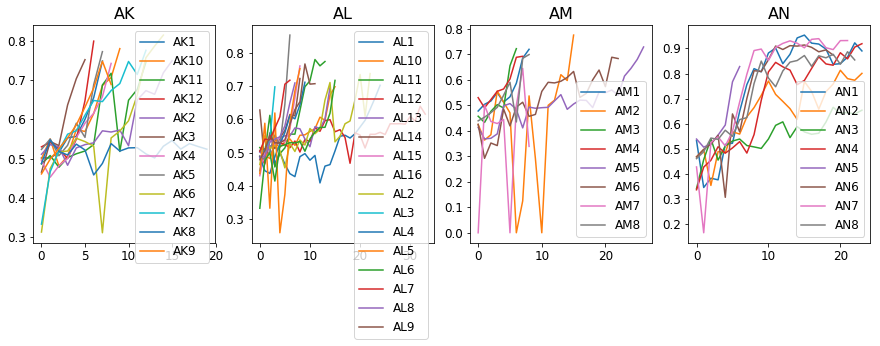

In [1068]:
fig, axes = pl.subplots(1, len(cohort_list), figsize=(15, 4))

for (cohort, animalid), g in perfdf[perfdf['phase']==1].groupby(['cohort', 'animalid']):
    axi = list(cohort_list).index(cohort)
    ax = axes[axi]
    
    session_list = [s for s, sg in g.sort_values(by='sessionid').groupby(['sessionid'])]
    mean_acc = [sg['overall_accuracy'].values[0] for s, sg in g.sort_values(by='sessionid').groupby(['sessionid'])]
    ax.plot(np.arange(0, len(session_list)), mean_acc, label=animalid)
    #ax.plot(session_list, mean_acc)
    ax.set_title(cohort)
    ax.legend()

In [504]:
figsz = {'AK': (6, 2),
         'AL': (8, 2),
         'AM': (4, 2)}


(2, 6)
(2, 8)
(2, 4)


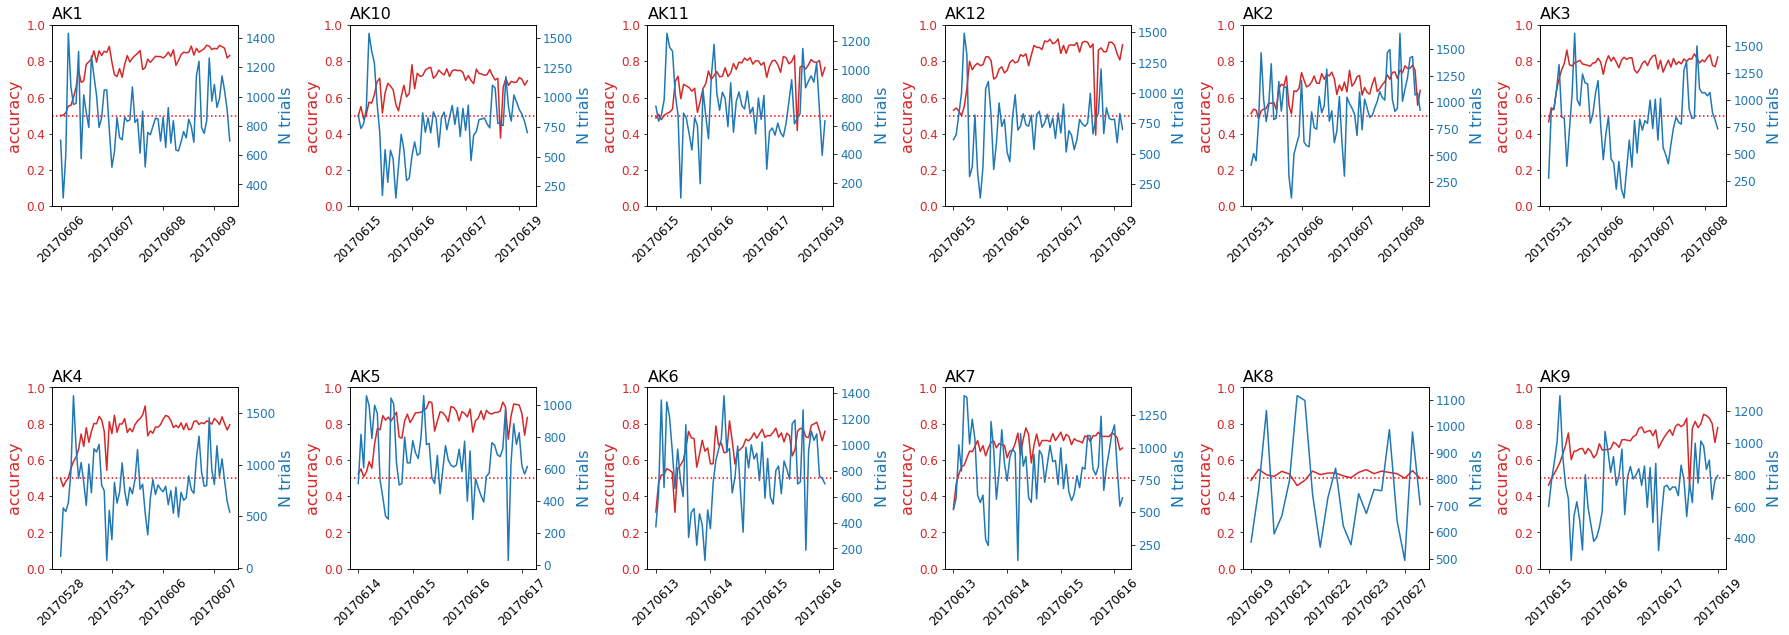

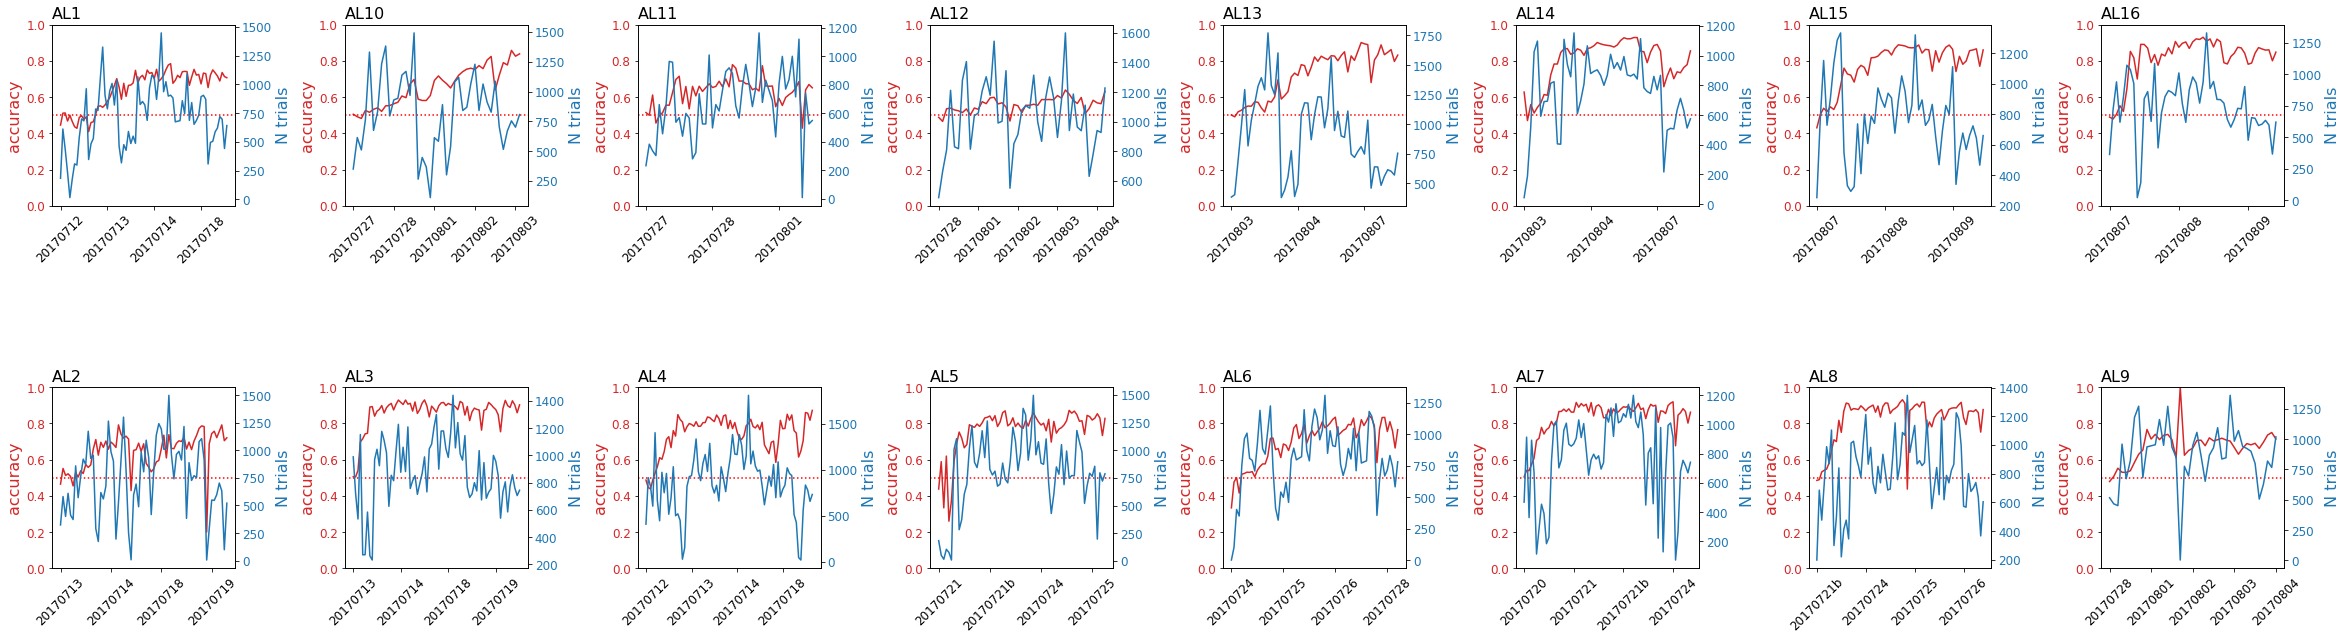

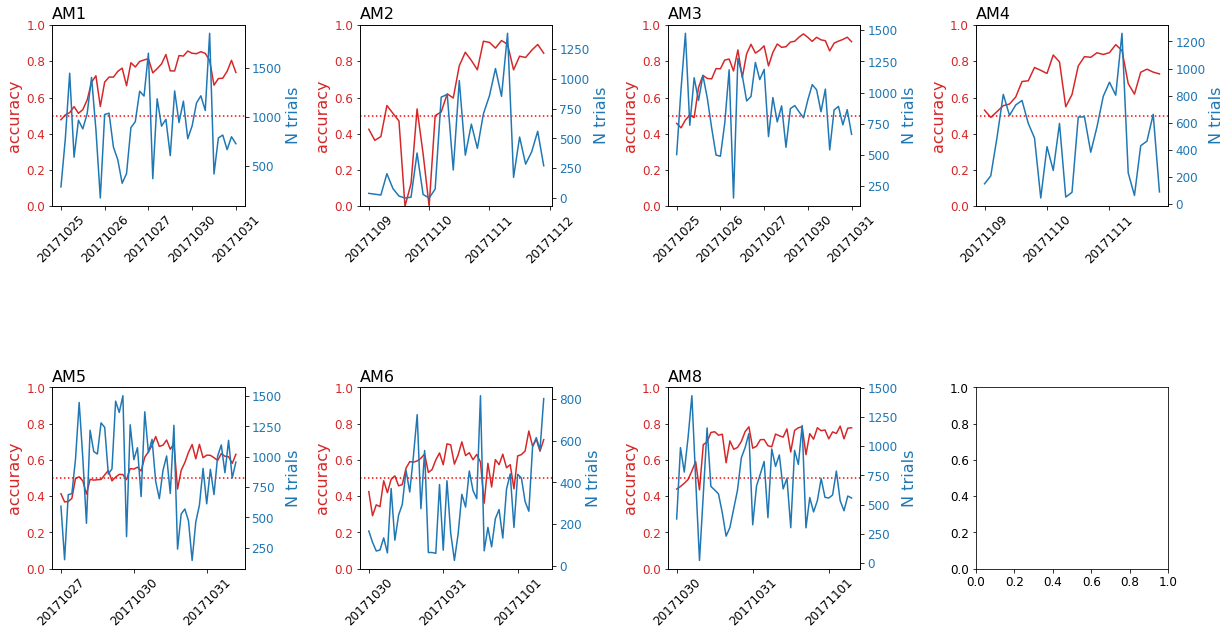

In [992]:
axis_colors = {0: 'tab:red', 1: 'tab:blue'}
figsz = {'AK': (6, 2),
         'AL': (8, 2),
         'AM': (4, 2)}

tdf =  standarddf.copy()


for cohort in tdf['cohort'].unique(): #curr_cohort_list:
    nc, nr = figsz[cohort]
    print(nr, nc)
    fig, axes = pl.subplots(nr, nc, figsize=(nc*5,nr*5))
    for ax, (animalid, ddf) in zip(axes.flat, tdf[tdf['cohort']==cohort].groupby(['animalid'])):

        xvs = [s for s, g in ddf.groupby(['sessionid'])]
        xis = np.arange(0, len(xvs))

        yvs= [g['overall_accuracy'].values[0] for s, g in ddf.groupby(['sessionid'])]
        ax.plot(xis, yvs, color=axis_colors[0])

        ax.tick_params(axis='y', labelcolor=axis_colors[0])
        ax.set_ylabel('accuracy', color=axis_colors[0])
        ax.set_ylim([0, 1])
        ax.axhline(y=0.5, linestyle=':', color='r')

        ax.set_xticklabels(xvs, rotation=45)
        #ax.tick_params(axis='x', rotation=45)

        ax2 = ax.twinx()
        twinvs = [g['n_trials'].values[0] for s, g in ddf.groupby(['sessionid'])]
        ax2.plot(xis, twinvs, color=axis_colors[1])
        ax2.tick_params(axis='y', labelcolor=axis_colors[1])
        ax2.set_ylabel('N trials', color=axis_colors[1])

        ax.set_title(animalid, loc='left')
        ax.set_xticklabels(xvs, rotation=45)

    pl.subplots_adjust(hspace=1, wspace=0.6)

    figname = 'by-animal_accuracy-and-ntrials_cohort-%s' % cohort

    pl.savefig(os.path.join(outdir, 'individuals', '%s.png' % figname))

(2, 6)
(2, 8)
(2, 4)


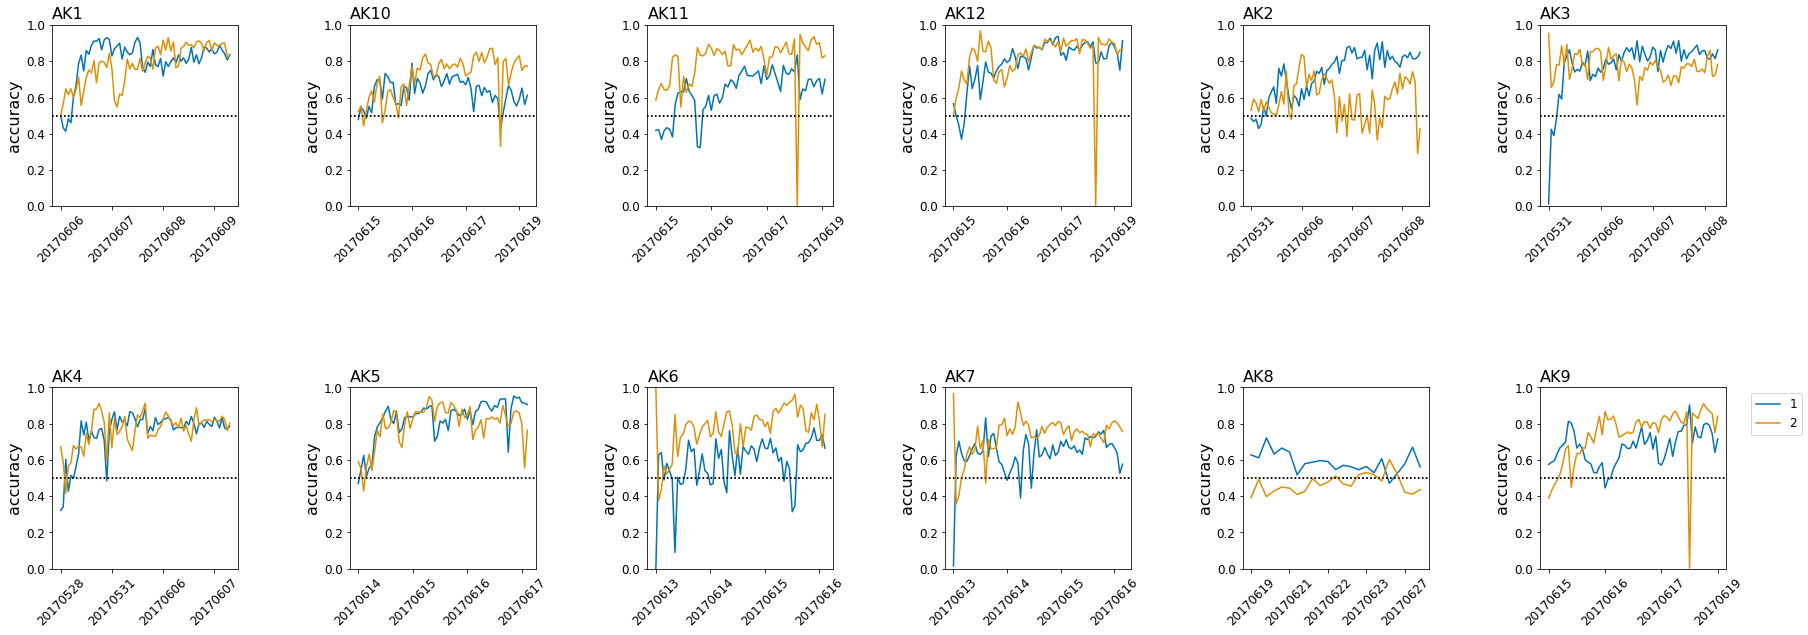

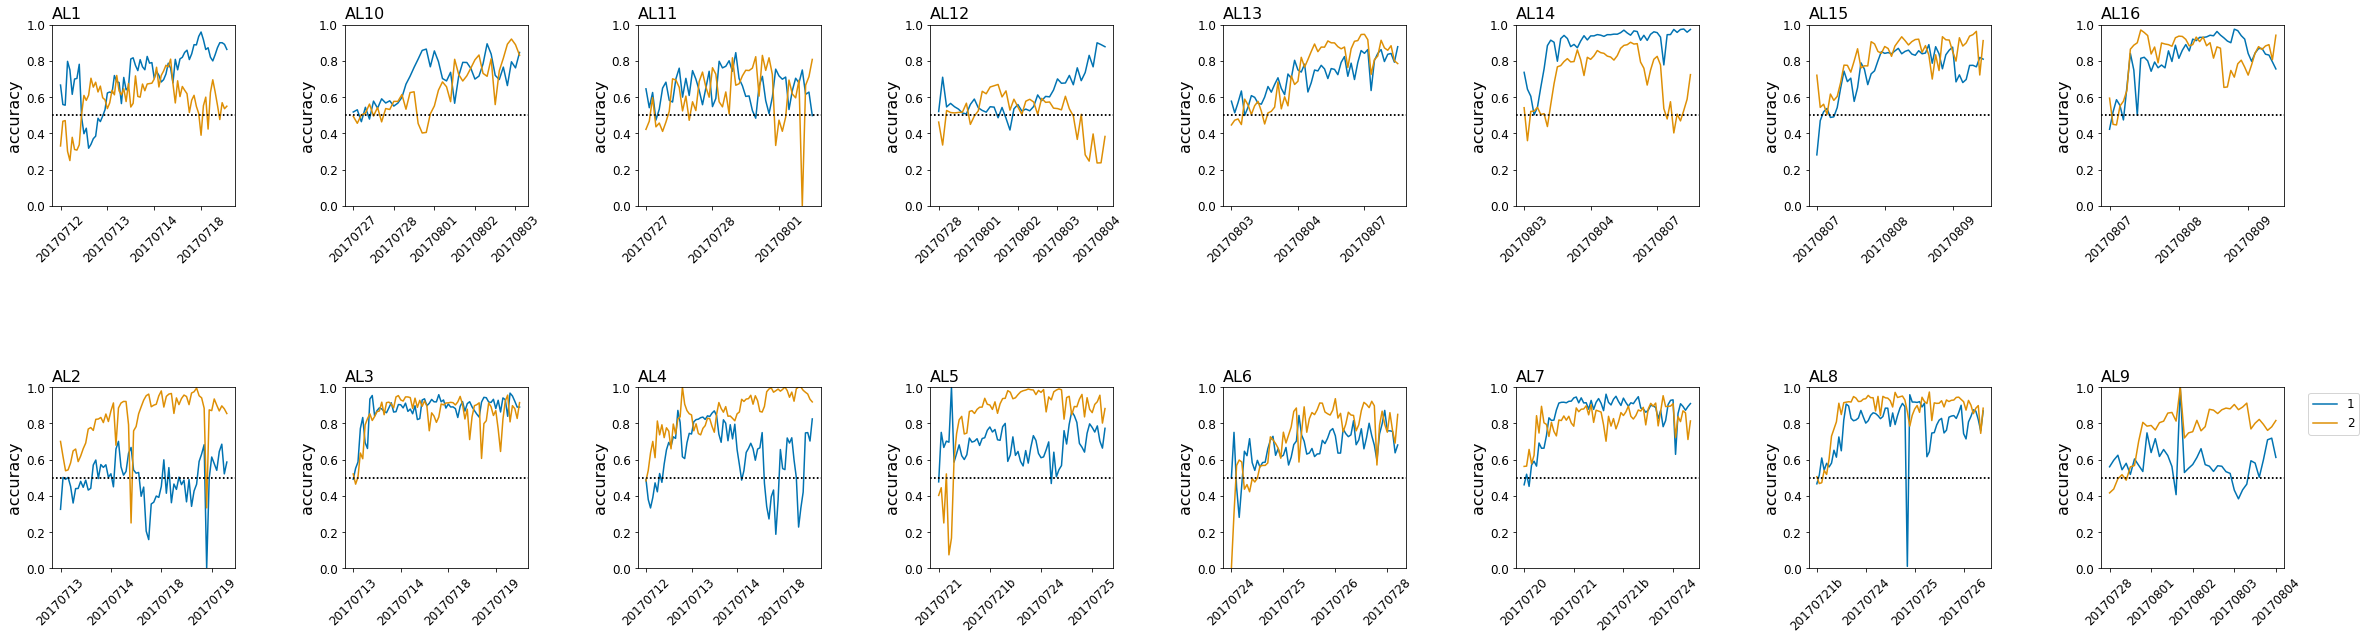

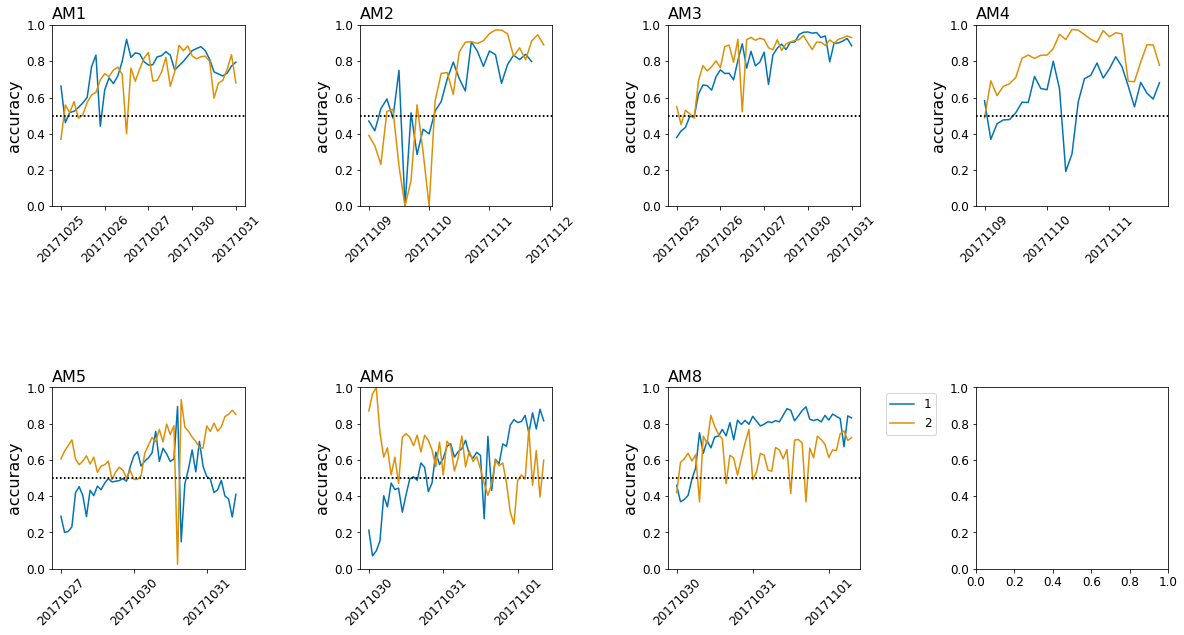

In [1028]:
curr_colors = feature_colors['objectid']

figsz = {'AK': (6, 2),
         'AL': (8, 2),
         'AM': (4, 2)}

tdf =  standarddf_split.copy()


for cohort in tdf['cohort'].unique(): #curr_cohort_list:
    nc, nr = figsz[cohort]
    print(nr, nc)
    fig, axes = pl.subplots(nr, nc, figsize=(nc*5,nr*5))
    for ax, (animalid, animaldf) in zip(axes.flat, tdf[tdf['cohort']==cohort].groupby(['animalid'])):
    
        for c_color, ((objectid), odf) in zip(curr_colors, animaldf.groupby(['objectid'])):

            xvs = [s for s, g in odf.groupby(['sessionid'])]
            xis = np.arange(0, len(xvs))

            yvs= [g['split_accuracy'].values[0] for s, g in odf.groupby(['sessionid'])]
            ax.plot(xis, yvs, color=c_color, label=objectid)

            ax.set_ylabel('accuracy')
            ax.set_ylim([0, 1])
            ax.axhline(y=0.5, linestyle=':', color='k')

            ax.set_xticklabels(xvs, rotation=45)
            #ax.tick_params(axis='x', rotation=45)

            ax.set_title(animalid, loc='left')
            ax.set_xticklabels(xvs, rotation=45)

    pl.subplots_adjust(hspace=1, wspace=0.6)
    ax.legend(bbox_to_anchor=(1.1, 1))
    
    figname = 'by-animal_split-accuracy_objectid_cohort-%s' % cohort
    pl.savefig(os.path.join(outdir, 'individuals', '%s.png' % figname))

## Plot stuff for single example animal

In [1034]:
last_session_in_phase = [g.sort_values(by='session')['session'].values[0] for p, g in animaldf.groupby(['phase'])]
last_session_in_phase


[20170531, 20170615, 20170617, 20170620]

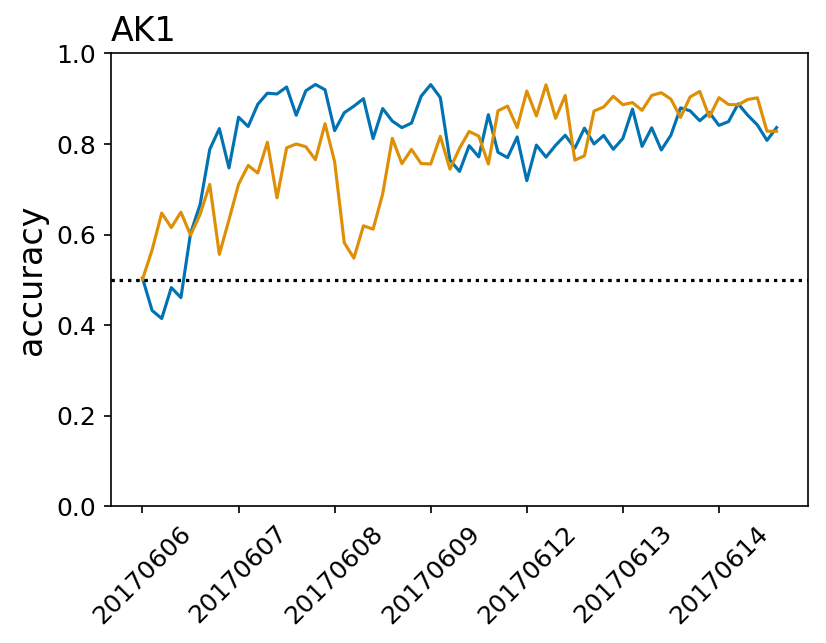

In [1030]:
animalid = 'AK1'
axis_colors = {0: feature_colors['twinx'][0], 
               1:  feature_colors['twinx'][1]}


animaldf = standarddf_split[standarddf_split['animalid']==animalid] 

fig, ax = pl.subplots(figsize=(6, 4), dpi=dpi)


for c_color, ((objectid), objectdf) in zip(curr_colors, animaldf.groupby(['objectid'])):

    session_list = [s for s, g in objectdf.groupby(['sessionid'])]
    session_ixs = np.arange(0, len(session_list))

    yvs= [g['split_accuracy'].values[0] for s, g in objectdf.groupby(['sessionid'])]
    ax.plot(session_ixs, yvs, color=c_color, label=objectid)

    ax.set_ylabel('accuracy')
    ax.set_ylim([0, 1])
    ax.axhline(y=0.5, linestyle=':', color='k')

    ax.set_xticklabels(session_list, rotation=45)
    #ax.tick_params(axis='x', rotation=45)

    ax.set_title(animalid, loc='left')
    ax.set_xticklabels(xvs, rotation=45)

for phase_s in       
# ax.tick_params(axis='y', labelcolor=axis_colors[0])
# ax.set_ylabel('accuracy', color=axis_colors[0])
# ax.set_ylim([0, 1])
# ax.axhline(y=0.5, linestyle=':', color='r')

# ax.set_xticklabels(xvs, rotation=45)
# #ax.tick_params(axis='x', rotation=45)

# ax2 = ax.twinx()
# twinvs = [g['n_trials'].values[0] for s, g in ddf.groupby(['sessionid'])]
# ax2.plot(xis, twinvs, color=axis_colors[1])
# ax2.tick_params(axis='y', labelcolor=axis_colors[1])
# ax2.set_ylabel('N trials', color=axis_colors[1])

# ax.set_title(animalid, loc='left')
# ax.set_xticklabels(xvs, rotation=45)

# pl.subplots_adjust(hspace=1, wspace=0.6)

# figname = 'by-animal_accuracy-and-ntrials_cohort-%s' % cohort

# pl.savefig(os.path.join(outdir, 'individuals', '%s.png' % figname))

# Visualize all animals

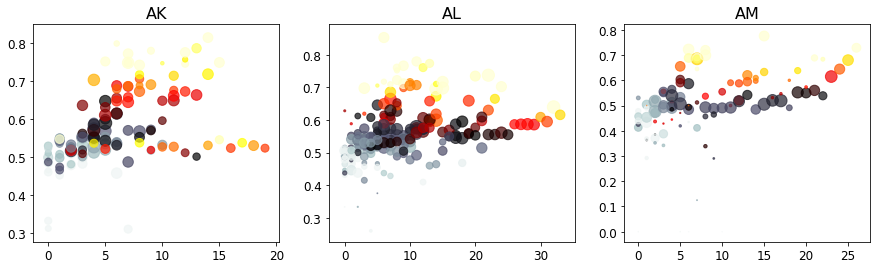

In [541]:
fig, axes = pl.subplots(1, len(curr_cohort_list), figsize=(15, 4))

for (cohort, animalid), g in perfdf_filt.groupby(['cohort', 'animalid']):
    axi = curr_cohort_list.index(cohort)
    ax = axes[axi]
    
    session_list = [s for s, sg in g.sort_values(by='sessionid').groupby(['sessionid'])]
    mean_acc = [sg['overall_accuracy'].values[0] for s, sg in g.sort_values(by='sessionid').groupby(['sessionid'])]
    
    ntrials = [sg['n_trials'].values[0]/10. for s, sg in g.sort_values(by='sessionid').groupby(['sessionid'])]

    ax.scatter(np.arange(0, len(session_list)), mean_acc, c=mean_acc, cmap=pnas_cmap,
               s=ntrials, label=animalid, alpha=0.7)
    ax.set_title(cohort)


In [673]:
perfdf_filt['phase'].unique()

array([1, 2, 3, 5])

In [717]:
perfdf_filt.iloc[0]['sessionid']

'20170531'

33 out of 35 animals with accuracy >= 0.70
('2 did not learn:', ['AK8', 'AL12'])


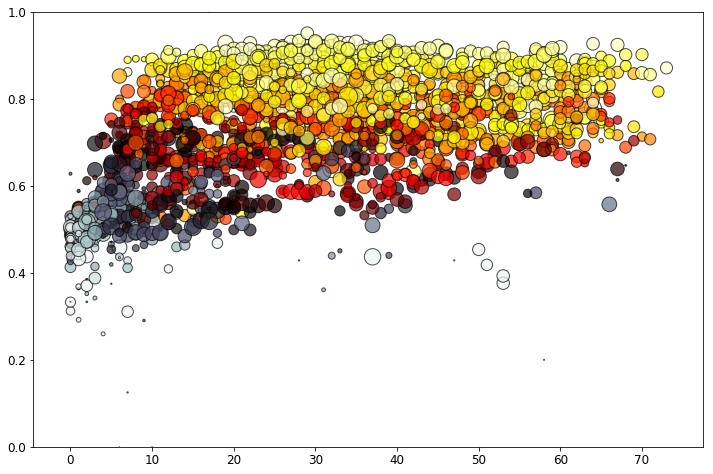

In [993]:
accuracies = {} # []
fig, ax = pl.subplots(figsize=(12, 8))

for (cohort, animalid), g in standarddf.groupby(['cohort', 'animalid']):
    
    session_list = [s for s, sg in g.sort_values(by='session').groupby(['sessionid'])]
    mean_acc = [sg['overall_accuracy'].values[0] for s, sg in g.sort_values(by='session').groupby(['sessionid'])]
    
    ntrials = [sg['n_trials'].values[0]/5. for s, sg in g.sort_values(by='session').groupby(['sessionid'])]
    
    accuracies.update({animalid: mean_acc})
    
    ax.scatter(np.arange(0, len(session_list)), mean_acc, c=mean_acc, cmap=pnas_cmap,
               s=ntrials, label=animalid, alpha=0.7, edgecolors='k')
    #ax.set_title(cohort)
    
ax.set_ylim([0, 1])

# Print sumamry
thr = 0.7
curr_animal_ids = standarddf['animalid'].unique()
animals_learned = standarddf[standarddf['overall_accuracy'] >= thr]['animalid'].unique()
print("%i out of %i animals with accuracy >= %.2f" % (len(animals_learned), len(curr_animal_ids), thr))
animals_didnt_learn = [i for i in curr_animal_ids if i not in animals_learned]

print("%i did not learn:" % len(animals_didnt_learn), animals_didnt_learn)


# Visualze all performance, sort sessions

In [821]:
max_nsessions = max([len(v) for k, v in accuracies.items()])
print(max_nsessions)

session_counts = dict((k, len(v)) for k, v in accuracies.items())

sorted_session_counts = [k for k, v in sorted(session_counts.items(), key=lambda x: x[1])][::-1] # np.argsort(session_counts)[::-1]


74

In [826]:
#### Create array to plot as heatmap
performance_mat = np.empty((len(curr_animal_ids), max_nsessions))
for ai, animalid in enumerate(sorted_session_counts):
    vals = accuracies[animalid]
    xvpad = np.pad(vals, ((0, max_nsessions-len(vals))), mode='constant', constant_values=np.nan)

    performance_mat[ai, :] = xvpad

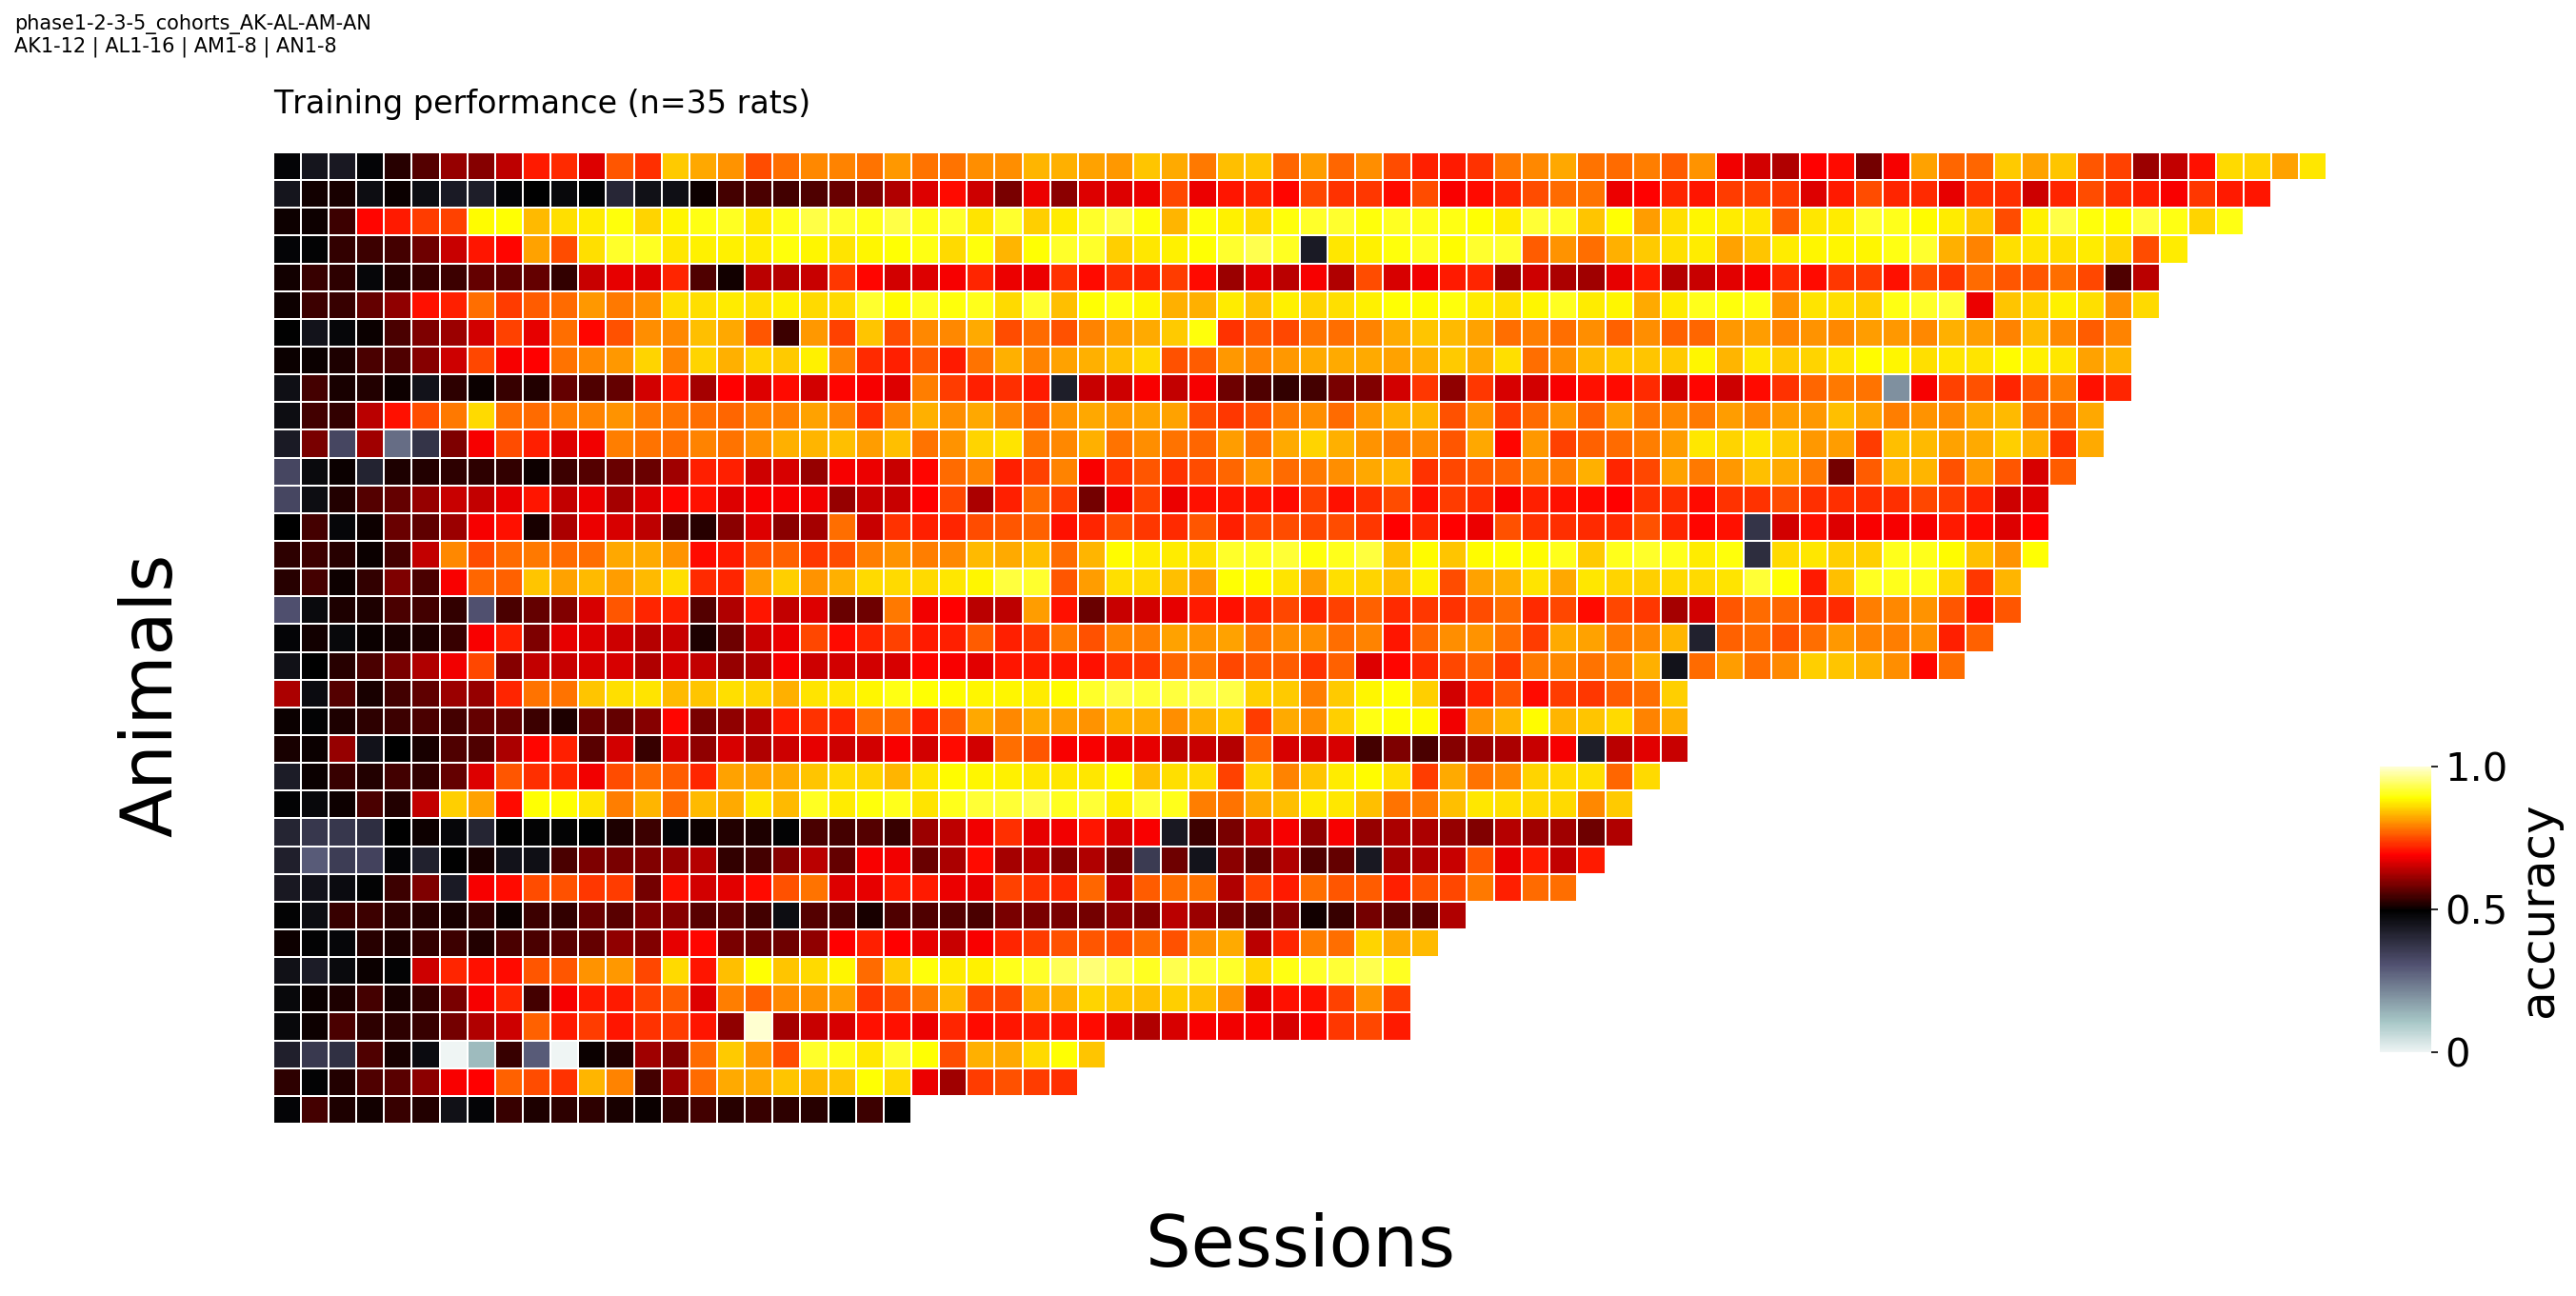

In [872]:
#### Plot performance array
fig, ax =pl.subplots(figsize=(18,10), dpi=dpi)
cbar_ax = fig.add_axes([.92, .25, .02, .2])
fig.patch.set_alpha(0.)
sns.heatmap(performance_mat, cmap=pnas_cmap, vmin=0, vmax=1, linewidths=0.5, square=True,
           cbar_ax=cbar_ax, cbar=1, ax=ax,
           cbar_kws=dict(ticks=[0, .5, 1.0]))
ax.tick_params(axis='x', size=0)
ax.axis('off')

pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2)
ax.set_title('Training performance (n=%i rats)' % performance_mat.shape[0], loc='left', pad=20)

fig.text(0.5, 0.1, 'Sessions', ha='center', fontsize=36)
fig.text(0.04, 0.5, 'Animals', va='center', rotation='vertical', fontsize=36)

#cbar_ax.yaxis.label.set_size(20)
cbar_ax.set_yticklabels([0, 0.5, 1.0], fontsize=20) #(20)
cbar_ax.set_ylabel('accuracy', fontsize=24) #(20)

fig.text(0, 0.95, figid)
pl.savefig(os.path.join(outdir, 'all_animals_heatmap_by_session_sorted.png'))
pl.savefig(os.path.join(outdir, 'all_animals_heatmap_by_session_sorted.svg'))

In [27]:
object_ids = df['object'].unique()
HMAPS = dict((animalid, dict((k, []) for k in object_ids)) for animalid in df['animalid'].unique())
no_feedback = {}

    
dlist = []
i=0
for (animalid, session, sfx), agroup in df.groupby(['animalid', 'session', 'suffix']):
    
    if curr_phase in [4, 5] and no_feedback_flag is True:
        no_fb = agroup[agroup['no_feedback']==True][feature_list]
        no_fb_configs = list(set([(s, d) for s, d, in zip(no_fb[row_feature].values, no_fb[col_feature].values)]))
        no_feedback[animalid] = no_fb_configs

    for objectname, ogroup in agroup.groupby(['object']):
        hmap = np.ones((len(row_values), len(col_values))) * np.nan

        for (drot, sz), sgroup in ogroup.groupby([col_feature, row_feature]):

            n_trials = float(sgroup['outcome'].shape[0])
            perc_correct = len(sgroup[sgroup['outcome']=='success']) / n_trials
            mean_rt = sgroup['response_time'].mean()

            r_ix = list(row_values).index(sz)
            c_ix = list(col_values).index(drot)

            hmap[r_ix, c_ix] = perc_correct

            dlist.append(pd.DataFrame({'perc_correct': perc_correct,
                                       'avg_rt': mean_rt,
                                          'n_trials': n_trials,
                                          '%s' % row_feature: sz,
                                          '%s' % col_feature: drot,
                                          'objectid': objectname,
                                          'animalid': animalid,
                                          'session': session,
                                          'suffix': sfx}, index=[i]))
            i+=1

        HMAPS[animalid][objectname].append(hmap)

perfdf = pd.concat(dlist, axis=0)       

for animalid, hmap_d in HMAPS.items():
    HMAPS[animalid] = dict((k, np.dstack(v)) for k, v in hmap_d.items())


# Plot

In [28]:
# font_params = {'legend.fontsize': 'large',
#                  'axes.labelsize': 'large',
#                  'axes.titlesize': 'large',
#                  'xtick.labelsize': 'large',
#                  'ytick.labelsize': 'large'}
font_params = {'legend.fontsize': 22,
                 'axes.labelsize': 36,
                 'axes.titlesize': 22,
                 'xtick.labelsize': 22,
                 'ytick.labelsize': 22}

pl.rcParams.update(font_params)

dpi=150
lw = 5


# Set current output dir for figures

In [30]:
curr_outdir

'/n/coxfs01/behavior-data/threeport/processed/GJ/phase-6/performance'

In [47]:
# if curr_phase == 6:
#     curr_outdir = os.path.join(processed_dir, 'performance', 'inplane_rotations')
# else:
#     curr_outdir = os.path.join(processed_dir, 'performance')

# if not os.path.exists(os.path.join(curr_outdir, 'by_animal')):
#     os.makedirs(os.path.join(curr_outdir, 'by_animal'))
# print(os.path.join(curr_outdir, 'by_animal'))

/n/coxfs01/behavior-data/threeport/processed/performance/by_animal


##### Test HEATMAP w/ 1 animal

In [48]:
len(col_values)*1.3

11.700000000000001

_annot_heatmap_split-object_phase-6_AG1


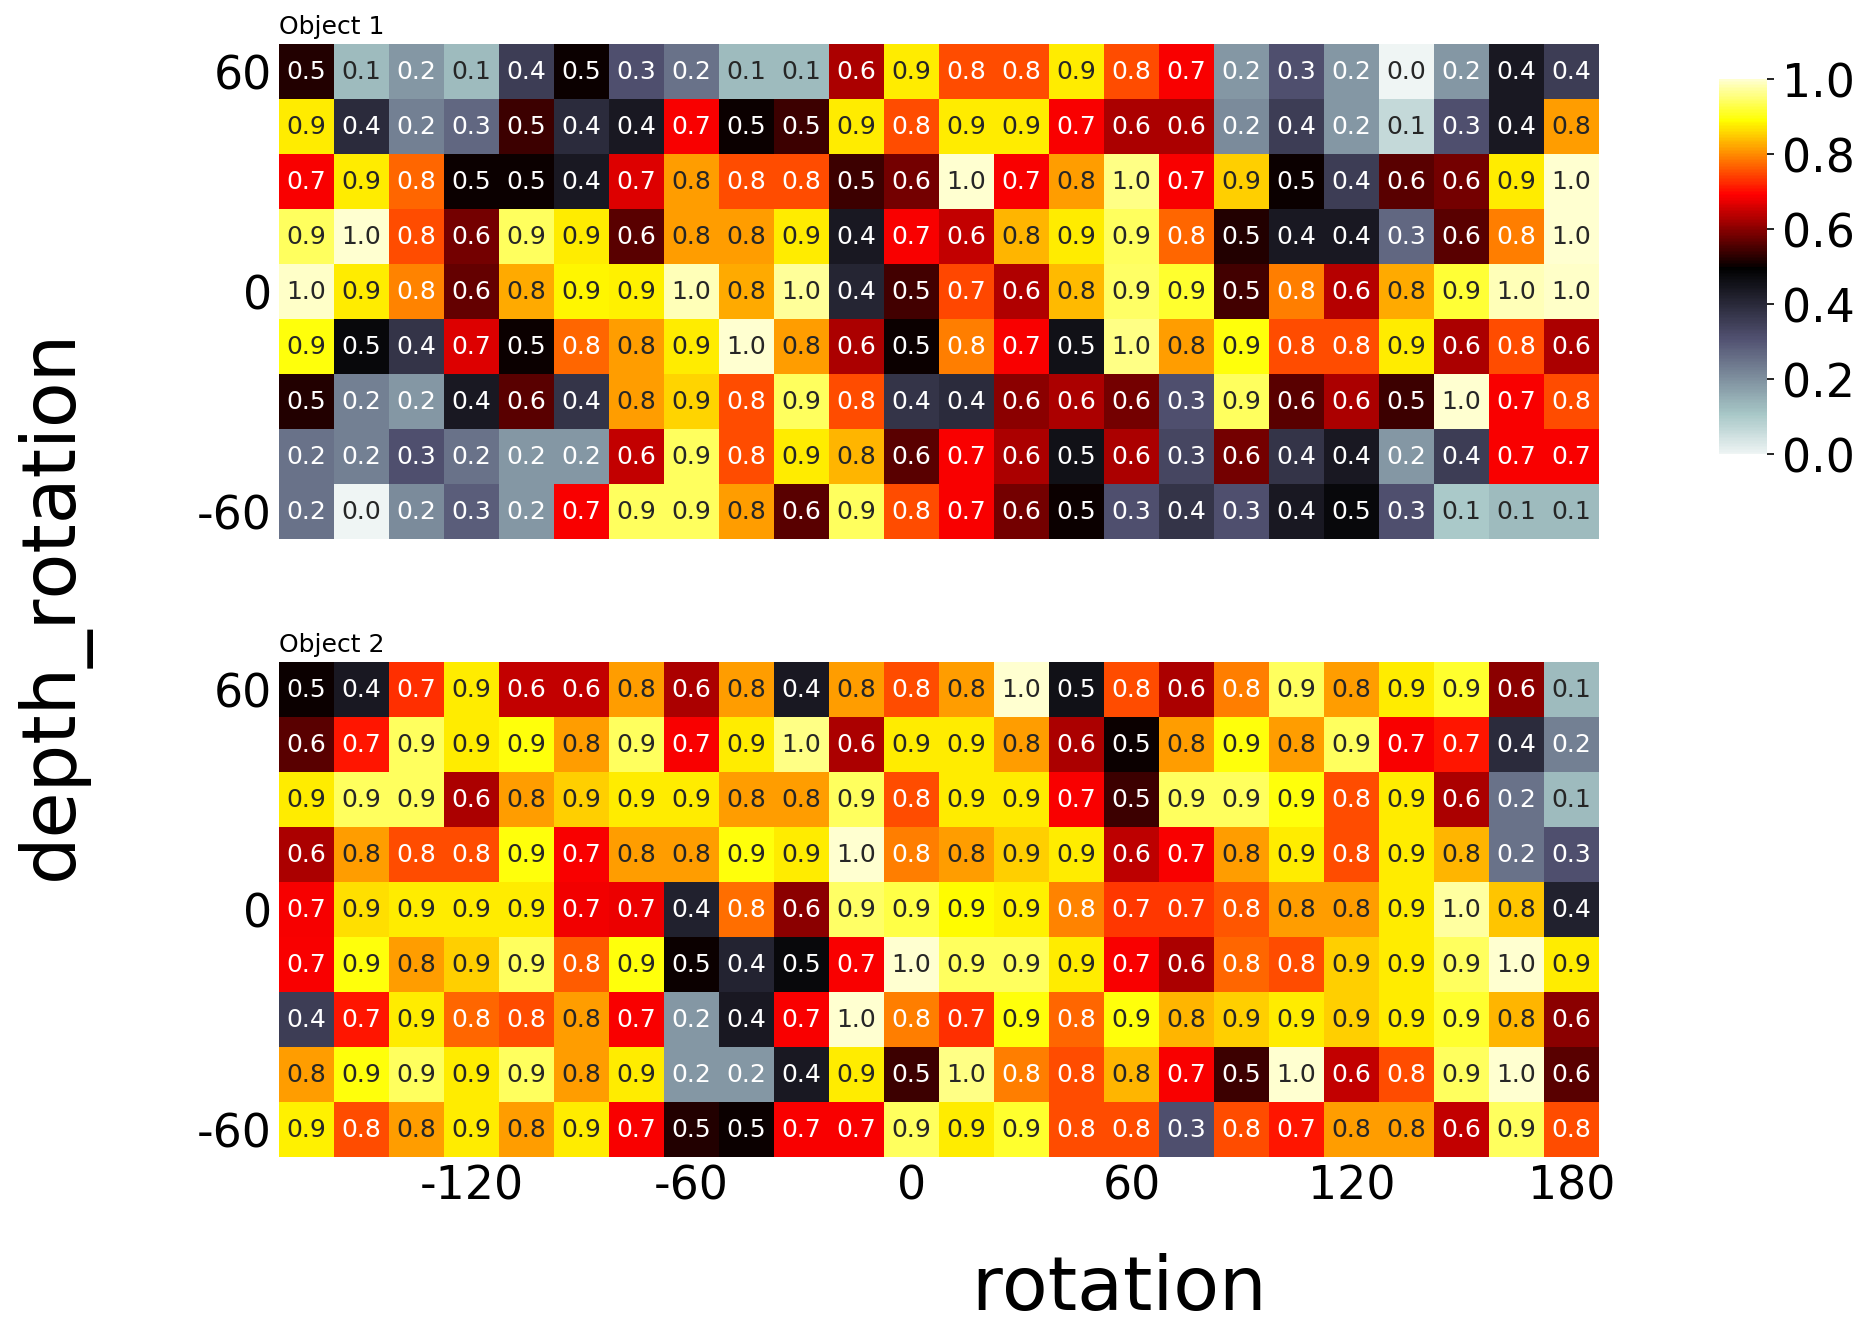

In [32]:
if curr_phase in [4, 5] and no_feedback_flag:
    curr_no_fb = no_feedback[animalid]
else:
    curr_no_fb = None
    
fw = min([ int(round(len(col_values)*1.2)), 16])
fh = len(object_ids)*5

annot=True
annot_str = '_annot_' if annot else ''

fig, axes = pl.subplots(2, 1, figsize=(fw, fh), 
                        dpi=dpi, sharex=True, sharey=True)

cbar_ax = fig.add_axes([0.75, 0.6, 0.02, 0.25])

hmap_d = HMAPS[animalid]
for oi, objectid in enumerate(object_ids):
    ax = axes[oi]
    hmap = np.nanmean(hmap_d[objectid], axis=-1)
    im = sns.heatmap(hmap, cmap=pnas_cmap, vmin=0, vmax=1, ax=ax,
                    cbar=oi==0, cbar_ax=0 if oi else cbar_ax, center=0.5, 
                     annot=annot, fmt=".1f",  annot_kws={"size": 12})

    format_size_depth_ticks(ax, xvals=col_values, yvals=row_values, xmax=xmax, ymax=ymax, seaborn=True)
    if curr_no_fb is not None:
        draw_no_feedback(ax, curr_no_fb, defaults, seaborn=True, lw=6)

    if annot:
        ax.set_title('Object %s' % objectid, fontsize=12, loc='left', pad=5)
    ax.tick_params(axis='both', size=0)

    ax.set_aspect('equal')
    ax.invert_yaxis()

if curr_no_fb is not None:
    ax.legend(bbox_to_anchor=(1.7, 1))

pl.subplots_adjust(hspace=0.2, wspace=0.1, right=0.7, left=0.15)

fig.text(0.5, 0.03, col_feature, ha='center', fontsize=36)
fig.text(0.04, 0.5, row_feature, va='center', rotation='vertical', fontsize=36)

figname = '%sheatmap_split-object_phase-%i_%s' % (annot_str, curr_phase, animalid)
print(figname)

#pl.savefig(os.path.join(curr_outdir, 'by_animal', '%s.svg' % figname))
pl.savefig(os.path.join(curr_outdir, 'by_animal', '%s.png' % figname))


In [921]:
outdir

'/n/coxfs01/behavior-data/threeport/processed/performance'

## Plot HEATMAP for all animals

In [47]:
plot_each_animal = True
transform_str = 'inplane_rotations' if curr_phase==6 else 'indepth_rotations'

#curr_outdir = os.path.join(processed_dir, 'performance', transform_str) #, 'by_animal')

if plot_each_animal:
    
    if not os.path.exists(os.path.join(curr_outdir, 'by_animal')):
        os.makedirs(os.path.join(curr_outdir, 'by_animal'))
print(os.path.join(curr_outdir, 'by_animal'))
                

/n/coxfs01/behavior-data/threeport/processed/GJ/phase-6/performance/by_animal


In [48]:
seaborn = True
annot=True

annot_str = '_annot_' if annot else ''

fw = min([len(col_values)*1.2, 16])
fh = len(object_ids)*5

if plot_each_animal:
    for ai, (animalid, hmap_d) in enumerate(HMAPS.items()):
        
        if curr_phase in [4, 5]:
            curr_no_fb = no_feedback[animalid]
        else:
            curr_no_fb = None

        fig, axes = pl.subplots(2, 1, figsize=(fw, fh), 
                                dpi=dpi, sharex=True, sharey=True)
        
        cbar_ax = fig.add_axes([0.7, 0.6, 0.02, 0.25])

        hmap_d = HMAPS[animalid]
        for oi, objectid in enumerate(object_ids):
            ax = axes[oi]
            hmap = np.nanmean(hmap_d[objectid], axis=-1)
            im = sns.heatmap(hmap, cmap=pnas_cmap, vmin=0, vmax=1, ax=ax,
                            cbar=oi==0, cbar_ax=0 if oi else cbar_ax, center=0.5, 
                             annot=annot, fmt=".1f",  annot_kws={"size": 12})

            format_size_depth_ticks(ax, xvals=col_values, yvals=row_values, xmax=xmax, ymax=ymax, seaborn=True)
            if curr_no_fb is not None:
                draw_no_feedback(ax, curr_no_fb, defaults, seaborn=True, lw=6)

            if annot:
                ax.set_title('Object %s' % objectid, fontsize=12, loc='left', pad=5)
            ax.tick_params(axis='both', size=0)

            ax.set_aspect('equal')
            ax.invert_yaxis()

        if curr_no_fb is not None:
            ax.legend(bbox_to_anchor=(1.7, 1))
            
        pl.subplots_adjust(hspace=0.2, wspace=0.1, right=0.7, left=0.15)

        fig.text(0.5, 0.03, col_feature, ha='center')
        fig.text(0.04, 0.5, row_feature, va='center', rotation='vertical')

        figname = '%sheatmap_split-object_phase-%i_%s' % (annot_str, curr_phase, animalid)
        print(figname)

        #pl.savefig(os.path.join(curr_outdir, 'by_animal', '%s.svg' % figname))
        pl.savefig(os.path.join(curr_outdir, 'by_animal', '%s.png' % figname))

        pl.close()

_annot_heatmap_split-object_phase-6_AJ12
_annot_heatmap_split-object_phase-6_AJ1
_annot_heatmap_split-object_phase-6_AJ4
_annot_heatmap_split-object_phase-6_AJ5
_annot_heatmap_split-object_phase-6_AG8
_annot_heatmap_split-object_phase-6_AG7
_annot_heatmap_split-object_phase-6_AG6
_annot_heatmap_split-object_phase-6_AG5
_annot_heatmap_split-object_phase-6_AG2
_annot_heatmap_split-object_phase-6_AG1


In [42]:
HMAPS.keys()

['AJ12', 'AJ1', 'AJ4', 'AJ5', 'AG8', 'AG7', 'AG6', 'AG5', 'AG2', 'AG1']

heatmap_split-object_phase-6_AG-AJ


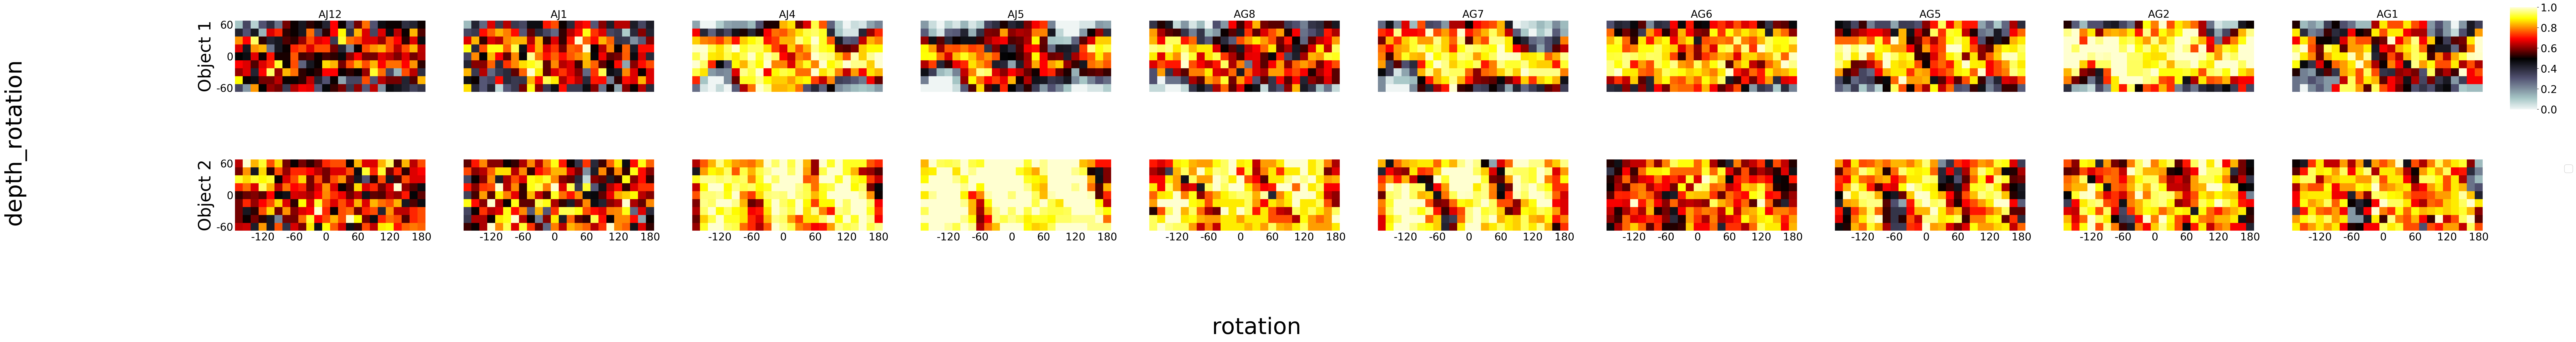

In [52]:
plot_each_animal=False
if not plot_each_animal:
    seaborn = True
    dpi=200

    fig, axes = pl.subplots(2, len(HMAPS.keys()), figsize=(len(animal_ids)*8, len(object_ids)*6), 
                            dpi=150, sharex=True, sharey=True)
    cbar_ax = fig.add_axes([0.96, 0.58, 0.01, 0.25])

    for ai, (animalid, hmap_d) in enumerate(HMAPS.items()):
        if curr_phase in [4, 5]:
            curr_no_fb = no_feedback[animalid]

        for oi, okey in enumerate(object_ids):
            ax = axes[oi, ai]
            hmap = np.nanmean(hmap_d[okey], axis=-1)
            if seaborn:
                im = sns.heatmap(hmap, cmap=pnas_cmap, vmin=0, vmax=1, ax=ax,
                                cbar=ai==0, cbar_ax=None if ai else cbar_ax)
            else:
                im = ax.imshow(hmap, origin='bottom', cmap=pnas_cmap, vmin=0, vmax=1)

            ax.set_aspect('equal')
            format_size_depth_ticks(ax, xvals=col_values, yvals=row_values, 
                                    xmax=xmax, ymax=ymax, seaborn=seaborn)
            if curr_phase in [4, 5]:
                draw_no_feedback(ax, curr_no_fb, defaults, seaborn=seaborn)
            #ax.set_title(animalid, fontsize=8, loc='left', pad=5)

            ax.tick_params(axis='both', size=0)
            if ai==0:
                ax.set_ylabel('Object %s' % okey)

            if seaborn:
                ax.invert_yaxis()
                
            if oi==0:
                ax.set_title(animalid)

    
    ax.legend(bbox_to_anchor=(1.5, 1))

    if not seaborn:
        cbar_ax = fig.add_axes([1.5, 0.58, 0.01, 0.25])
        fig.colorbar(im, cax=cbar_ax)

    pl.subplots_adjust(hspace=0.0, wspace=0.2, right=0.95, bottom=0.2)

    fig.text(0.5, 0.03, col_feature, ha='center', fontsize=48)
    fig.text(0.04, 0.5, row_feature, va='center', rotation='vertical', fontsize=48)


    figname = 'heatmap_split-object_phase-%i_%s' % (curr_phase, '-'.join(cohort_list))
    print(figname)

    #pl.savefig(os.path.join(curr_outdir, '%s.svg' % figname))
    pl.savefig(os.path.join(curr_outdir, '%s.png' % figname))
    #pl.close()

## Plot no-feedback performance only

In [64]:
curr_outdir = os.path.join(processed_dir, 'performance', 'no_feedback') #, 'by_animal')


In [65]:
twin_metric = 'avg_rt'
curr_metric = 'perc_correct'

dlist = []
incl_animals = [k for k, v in no_feedback.items() if len(v) > 0]
for animalid in incl_animals:
    fb_sizes = [f[0] for f in no_feedback[animalid]]
    fb_drots = [f[1] for f in no_feedback[animalid]]

    avg_accuracy = perfdf[(perfdf['animalid']==animalid) 
                   & (perfdf['size'].isin(fb_sizes)) 
                   & (perfdf['depth_rotation'].isin(fb_drots))].groupby(['session']).mean()[curr_metric]
    
    avg_rt = perfdf[(perfdf['animalid']==animalid) 
                   & (perfdf['size'].isin(fb_sizes)) 
                   & (perfdf['depth_rotation'].isin(fb_drots))].groupby(['session']).mean()[twin_metric]
    
    default_accuracy = perfdf[(perfdf['animalid']==animalid) 
                   & (perfdf['size']==default_size) 
                   & (perfdf['depth_rotation']==default_depth_rotation)].groupby(['session']).mean()[curr_metric]
    
    default_rt = perfdf[(perfdf['animalid']==animalid) 
                   & (perfdf['size']==default_size) 
                   & (perfdf['depth_rotation']==default_depth_rotation)].groupby(['session']).mean()[twin_metric]
    
    relative_accuracy = []
    dlist.append(pd.DataFrame({'mean_accuracy': avg_accuracy,
                              'mean_rt': avg_rt,
                               'default_accuracy': default_accuracy,
                               'default_rt': default_rt,
                              'animalid': [animalid for _ in np.arange(0, len(avg_rt))]}))
    
fb_df = pd.concat(dlist, axis=0).reset_index(drop=True)


In [66]:
fb_df['relative_accuracy'] = fb_df['mean_accuracy'] / fb_df['default_accuracy']
fb_df['relative_rt'] = fb_df['mean_rt'] / fb_df['default_rt']


fb_df = fb_df.replace([np.inf, -np.inf], np.nan).dropna()

fb_animal_ids = sorted(fb_df['animalid'].unique(), key=util.natural_keys)


no_feedback_mean_accuracy-by-animal_AJ


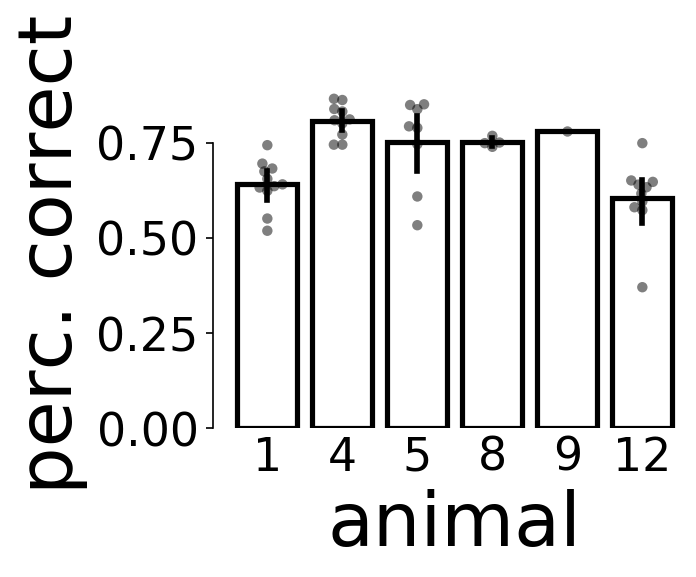

In [71]:
fig, ax = pl.subplots(dpi=dpi, figsize=(5,4))

curr_metric = 'mean_accuracy'
sns.barplot(x='animalid', y=curr_metric, order=fb_animal_ids,
            data=fb_df, ax=ax, 
            linewidth=2.5, facecolor=(1, 1, 1, 0),
            errcolor='k', edgecolor='k')
sns.swarmplot(x='animalid', y=curr_metric,  order=fb_animal_ids,
              data=fb_df, ax=ax, color='k', alpha=0.5)
ax.tick_params(axis='x', size=0)

sns.despine(trim=True, offset=8, bottom=True)

ax.set_xticklabels([int(a[2:]) for a in fb_animal_ids])
pl.subplots_adjust(left=0.3, right=0.9, bottom=0.3)
if 'accuracy' in curr_metric:
    ax.set_ylabel('perc. correct')
else:
    ax.set_ylabel('reaction time (s)')
ax.set_xlabel('animal')

figname = 'no_feedback_%s-by-animal_%s' % (curr_metric, cohort)
print(figname)

pl.savefig(os.path.join(curr_outdir, '%s.png' % figname))


In [703]:
[int(a[2:]) for a in fb_animal_ids]

[1, 2, 3, 4, 5, 7, 8]

# General performance and RT